# Import Packages

In [1]:
#-------------------------------------------------------------------------------------------------------------------------------
# IMPORT PACKAGES
#-------------------------------------------------------------------------------------------------------------------------------
%matplotlib inline

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.pyplot import cm
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML

# Functions

In [2]:


def moving_average(numbers, window_size) :
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

def add_temperature_features() :
    if device == 'Nano' :
        axs.axhline(y=97, color='red',alpha=0.3,zorder=0)
        axs.set_ylim([40,100])

    elif device == 'RPi' :
        axs.axhline(y=80, color='red',alpha=0.3,zorder=0)
        axs.axhspan(80,85, color='red',alpha=0.1,label='Throttling Temperature',zorder=0)
        axs.axhline(y=85, color='red',alpha=0.3,zorder=0)
        axs.set_ylim([50,90])
    
    axs.axhline(y=threshold, color='green',alpha=1,label='Desired Temperature',zorder=0)
        
    axs.set_ylabel('Temperature ($^\circ$C)')
    axs.set_title('{} Temperature'.format(net_name))
    axs.grid()
    # axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.95))
    axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6))
    axs.set_xlabel('Time (s)')    
    
def add_loop_features() :
    axs.set_ylabel('Loop Length (s)')
    axs.set_title('{} Loop Length'.format(net_name))
    axs.grid()
    axs.set_xlabel('Time (s)')
    axs.legend(loc='lower center', bbox_to_anchor=(0.5, -1.15))
    
def add_cpu_features() :
    axs.set_ylim([0,100])        
    axs.set_ylabel('CPU Usage (%)')
    axs.set_xlabel('Time (s)')
    axs.set_title('{} CPU Usage'.format(net_name))
    axs.grid()
    axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.73))
    
def generate_graphing_data(working_df) :
    for k, variable in enumerate(['temp_record_CPU', 'loop_duration_record', 'cpu_record']) :
        graphing_times = np.linspace(0,
             working_df['time_record'][working_df.index[-1]], 
             int(working_df['time_record'][working_df.index[-1]]))
        graphing_times = graphing_times.tolist()
        graphing_data = [0]
        for x in working_df['time_record']:
            for y in graphing_times:
                if x >= y and y > graphing_times[len(graphing_data)-1]:
                    graphing_times_index = graphing_times.index(y)
                    time_index = working_df.index[working_df['time_record']==x].tolist()
                    graphing_data.append(working_df[variable][time_index[0]]) 
        if k == 0 : graphing_temp = graphing_data
        if k == 2 : graphing_cpu = graphing_data
        if k == 1 : graphing_loopLength = graphing_data
    return graphing_temp, graphing_cpu, graphing_loopLength

# Load Data

## File Location

In [3]:
# Define parts of file location
parent_directory = '/Users/michaeldawson/Documents/GitHub/Research/TestBatches'

batch_name = '2022-03-28--15-31-50--Alg1RPi' # Good Algs 1 RPi
# batch_name = '2022-03-16--21-08-26--Alg1Nano' # Good Algs 1 Nano

# batch_name = '2022-03-28--11-17-19--Alg23RPi' # Good Algs 2 and 3, RPi
# batch_name = '2022-03-28--11-17-35--Alg23Nano' # Good Algs 2 and 3, Nano

# batch_name = '2022-03-30--10-37-09--Algs123Nano2'

# batch_name = '2022-04-20--14-15-34--Alg3RPiRedo' # Revised Alg 3 RPi
# batch_name = '2022-04-20--14-16-13--Alg3NanoRedo' # Revices Alg 3 Nano


# batch_name = '2022-03-30--10-44-28--Alg4ValRPi' # RPi Q-table Validation
# batch_name = '2022-03-31--11-02-59--Alg4RPiVal2'
# batch_name = '2022-03-31--18-45-32--Alg4RPiVal3'

# batch_name = '2022-03-31--18-42-42--Alg4NanoVal' # Nano Q-table Validation
# batch_name = '2022-03-31--18-59-45--Alg4NanoVal2GPU'
# batch_name = '2022-03-31--20-34-42--Alg4NanoVal3GPU'


## Load Data

In [4]:


# Combine parts of file location
batch_path = os.path.join(parent_directory,batch_name)
batch_data = pd.read_csv(os.path.join(batch_path,"batch_data.csv"),index_col=0)
device = batch_data['device'][0]
if device == 'nano' : device = 'Nano'
if device == 'rpi' : device = 'RPi'

NETs = ['efficientdet_lite4_detection_metadata_2',
            'efficientdet_lite3_detection_metadata_1',
            'efficientdet_lite2_detection_metadata_1',
            'efficientdet_lite1_detection_metadata_1',
            'efficientdet_lite0_detection_metadata_1'
            ]

# Load in Data
old_df = None
test_data = {}
test_number = 0
q_tables = {}

if batch_data['alg1'][0] == True :
    alg1_path = os.path.join(batch_path,"alg1")
    
    for k, net in enumerate(NETs) :
        net_path = os.path.join(alg1_path,'{}'.format(net))
        
        # Read in test parameters
        test_data['test_params_alg1_net{}'.format(net)] = pd.read_csv(os.path.join(net_path,"test_params.csv"),index_col=0)
        
        # test_data['test_params_alg1_net{}'.format(net)] = pd.DataFrame({'stop':300,'threshold_temp':75,'start_temp':50,'start_net':net},index=[0])
        
        # Read in data from CSV into Pandas Dataframe
        test_data['metadata_alg1_net{}'.format(net)] = pd.read_csv(os.path.join(net_path,"metadata.csv"),index_col=0)
        
        # Read in data from testing spreadsheet
        test_data['df_alg1_net{}'.format(net)] = {}
        for i in range(0,len(test_data['metadata_alg1_net{}'.format(net)].index)):
            test_data['df_alg1_net{}'.format(net)][i] = pd.read_excel(os.path.join(net_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))
            
            #
            # new_df = pd.read_excel(os.path.join(net_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(25*k + i+1))
            new_df = pd.read_excel(os.path.join(net_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))

            for key in list(test_data['test_params_alg1_net{}'.format(net)].keys()) :
                new_df[key] = test_data['test_params_alg1_net{}'.format(net)][key].tolist() * len(new_df) 
            for key in list(test_data['metadata_alg1_net{}'.format(net)].keys()) :
                new_df[key] = [test_data['metadata_alg1_net{}'.format(net)][key].tolist()[i]] * len(new_df) 
            new_df['alg'] = ['alg1']*len(new_df)
            
            new_df['test_number'] = [test_number] * len(new_df)
            test_number += 1

            if old_df is None : old_df = new_df
            else : old_df = pd.concat([old_df, new_df], ignore_index = True)
            
            
            #
            

if batch_data['alg2'][0] == True :
    alg2_path = os.path.join(batch_path,"alg2")
    # Read in test parameters
    test_data['test_params_alg2'] = pd.read_csv(os.path.join(alg2_path,"test_params.csv"),index_col=0)
    # Read in data from CSV into Pandas Dataframe
    test_data['metadata_alg2'] = pd.read_csv(os.path.join(alg2_path,"metadata.csv"),index_col=0)
    # Read in data from testing spreadsheet
    test_data['df_alg2'] = {}
    for i in range(0,len(test_data['metadata_alg2'].index)):
        test_data['df_alg2'][i] = pd.read_excel(os.path.join(alg2_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))
        
        #
        new_df = pd.read_excel(os.path.join(alg2_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))
        for key in list(test_data['test_params_alg2'].keys()) :
            new_df[key] = test_data['test_params_alg2'][key].tolist() * len(new_df) 
        for key in list(test_data['metadata_alg2'].keys()) :
            new_df[key] = [test_data['metadata_alg2'][key].tolist()[i]] * len(new_df) 
        new_df['alg'] = ['alg2']*len(new_df)
        
        new_df['test_number'] = [test_number] * len(new_df)
        test_number += 1
        
        if old_df is None : old_df = new_df
        else : old_df = pd.concat([old_df, new_df], ignore_index = True)
        #

        
if batch_data['alg3'][0] == True :
    alg3_path = os.path.join(batch_path,"alg3")
    # Read in test parameters
    test_data['test_params_alg3'] = pd.read_csv(os.path.join(alg3_path,"test_params.csv"),index_col=0)
    # Read in data from CSV into Pandas Dataframe
    test_data['metadata_alg3'] = pd.read_csv(os.path.join(alg3_path,"metadata.csv"),index_col=0)
    # Read in data from testing spreadsheet
    test_data['df_alg3'] = {}
    for i in range(0,len(test_data['metadata_alg3'].index)):
        test_data['df_alg3'][i] = pd.read_excel(os.path.join(alg3_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))

        #
        new_df = pd.read_excel(os.path.join(alg3_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))
        for key in list(test_data['test_params_alg3'].keys()) :
            new_df[key] = test_data['test_params_alg3'][key].tolist() * len(new_df) 
        for key in list(test_data['metadata_alg3'].keys()) :
            new_df[key] = [test_data['metadata_alg3'][key].tolist()[i]] * len(new_df) 
        new_df['alg'] = ['alg3']*len(new_df)

        new_df['test_number'] = [test_number] * len(new_df)
        test_number += 1
        
        if old_df is None : old_df = new_df
        else : old_df = pd.concat([old_df, new_df], ignore_index = True)
        #
        
if batch_data['alg4'][0] == True :
    alg4_path = os.path.join(batch_path,"alg4")
    # Read in test parameters
    test_data['test_params_alg4'] = pd.read_csv(os.path.join(alg4_path,"test_params.csv"),index_col=0)
    # Read in data from CSV into Pandas Dataframe
    test_data['metadata_alg4'] = pd.read_csv(os.path.join(alg4_path,"metadata.csv"),index_col=0)
    # Read in data from testing spreadsheet
    test_data['df_alg4'] = {}
    for i in range(0,len(test_data['metadata_alg4'].index)):
        test_data['df_alg4'][i] = pd.read_excel(os.path.join(alg4_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))

        #
        new_df = pd.read_excel(os.path.join(alg4_path,"data.xlsx"),index_col=0,sheet_name="Test{}".format(i+1))
        for key in list(test_data['test_params_alg4'].keys()) :
            new_df[key] = test_data['test_params_alg4'][key].tolist() * len(new_df) 
        for key in list(test_data['metadata_alg4'].keys()) :
            new_df[key] = [test_data['metadata_alg4'][key].tolist()[i]] * len(new_df) 
        new_df['alg'] = ['alg4']*len(new_df)
        
        new_df['test_number'] = [test_number] * len(new_df)
        test_number += 1
        
        if old_df is None : old_df = new_df
        else : old_df = pd.concat([old_df, new_df], ignore_index = True)
        #
        
data = old_df

In [38]:
data

iterator_record  time_record  temp_record_CPU  temp_record_GPU  \
0                     0     0.000000           53.069             53.5   
1                     0     1.575969           53.069             53.5   
2                     1     1.631830           53.556             52.5   
3                     1     3.209514           55.504             56.9   
4                     2     3.267383           56.965             56.0   
...                 ...          ...              ...              ...   
147298             1396   299.704077           68.166             68.1   
147299             1396   299.840955           69.140             69.1   
147300             1397   299.911288           69.140             69.6   
147301             1397   300.048262           70.601             69.1   
147302             1398   300.238875           68.653             68.6   

        cpu_record  processing_duration_record  pause_duration_record  \
0              0.0                    0.000000                 0.0000   
1              8.3                    1.575969                 0.0000   
2             30.4                    1.575969                 0.0000   
3             82.9                    1.577684                 0.0000   
4             48.1                    1.577684                 0.0000   
...            ...                         ...                    ...   
147298        25.0                    0.142843                 0.0000   
147299        54.9                    0.136878                 0.0000   
147300        28.6                    0.136878                 0.0000   
147301        54.3                    0.136974                 0.0000   
147302        10.4                    0.136974                 0.1202   

        loop_duration_record                               net_record  \
0                   0.000000  efficientdet_lite4_detection_metadata_2   
1                   0.000000  efficientdet_lite4_detection_metadata_2   
2                   1.631830  efficientdet_lite4_detection_metadata_2   
3                   1.631830  efficientdet_lite4_detection_metadata_2   
4                   1.635553  efficientdet_lite4_detection_metadata_2   
...                      ...                                      ...   
147298              0.213282  efficientdet_lite0_detection_metadata_1   
147299              0.213282  efficientdet_lite0_detection_metadata_1   
147300              0.207211  efficientdet_lite0_detection_metadata_1   
147301              0.207211  efficientdet_lite0_detection_metadata_1   
147302              0.327587  efficientdet_lite0_detection_metadata_1   

        avg_accuracy_record  stop  threshold_temp  start_temp  \
0                    0.4196   300              70          50   
1                    0.4196   300              70          50   
2                    0.4196   300              70          50   
3                    0.4196   300              70          50   
4                    0.4196   300              70          50   
...                     ...   ...             ...         ...   
147298               0.2569   300              70          50   
147299               0.2569   300              70          50   
147300               0.2569   300              70          50   
147301               0.2569   300              70          50   
147302               0.2569   300              70          50   

                                      start_net  \
0       efficientdet_lite4_detection_metadata_2   
1       efficientdet_lite4_detection_metadata_2   
2       efficientdet_lite4_detection_metadata_2   
3       efficientdet_lite4_detection_metadata_2   
4       efficientdet_lite4_detection_metadata_2   
...                                         ...   
147298  efficientdet_lite0_detection_metadata_1   
147299  efficientdet_lite0_detection_metadata_1   
147300  efficientdet_lite0_detection_metadata_1   
147301  efficientdet_lite0_detection_metadata_1   
147302  efficientdet_li

In [42]:
(data[data['pause_duration_record']==0]['processing_duration_record'][3:]/data[data['pause_duration_record']==0]['loop_duration_record'][3:])

3         0.966819
4         0.964618
5         1.117031
6         0.970545
7         0.742925
            ...   
147297    0.642855
147298    0.669738
147299    0.641770
147300    0.660573
147301    0.661036
Length: 97517, dtype: float64

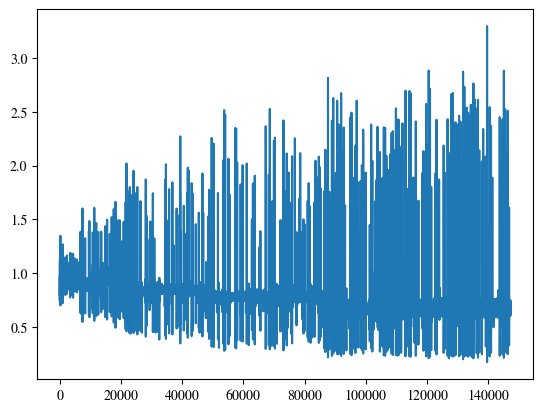

In [39]:
plt.plot((data[data['pause_duration_record']==0]['processing_duration_record'][3:]/data[data['pause_duration_record']==0]['loop_duration_record'][3:]))

# Settings

In [6]:
# Get parameter values from data
threshold = data['threshold_temp'].tolist()[0]
end_of_detections = data['stop'].tolist()[0]
start_temp = data['start_temp'].tolist()[0]

# Define lists of parameter values
ALGs = pd.unique(data['alg'].dropna())
TESTs = pd.unique(data['test_number'].dropna())
if 'pause_adjustment_coef_records' in data :
    PACs = pd.unique(data['pause_adjustment_coef_records'].dropna())
else : PACs = []
if 'initial_pause_duration_records' in data :
    IPDs = pd.unique(data['initial_pause_duration_records'].dropna())
else : IPDs = []
if 'strat_record' in data :
    STRATs = pd.unique(data['strat_record'].dropna()).astype(int)
else : STRATs = []
if 'TAC_record' in data :
    TACs = pd.unique(data['TAC_record'].dropna()).astype(int)
else : TACs = []
    
net_names = ['EfficientDet-Lite4',
               'EfficientDet-Lite3',
               'EfficientDet-Lite2',
               'EfficientDet-Lite1',
               'EfficientDet-Lite0'
               ]
net_dict = {}
for k, net in enumerate(net_names) :
    net_dict[NETs[k]] = net

# Set MPL style
plt.style.use('default')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 100


import matplotlib.colors as colors
# This is a function from StackOverflow which takes a MPL colormap and can cuts off a defined amount
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

working_plasma = cmap = plt.get_cmap('plasma')
working_plasma = truncate_colormap(working_plasma, 0, 0.8)

# For cleanliness, define commonly used figure dimensions and moving average window
fig_width = 8
fig_height = 4
moving_average_window = 20

# colors = cm.plasma(np.linspace(0, 0.8, len(data['pause_adjustment_coef_records'])))


vis_path = '/Users/michaeldawson/Documents/GitHub/Research/Visuals'

In [7]:
print(start_temp)

50


# Visualizations

## Alg1 

### Combined

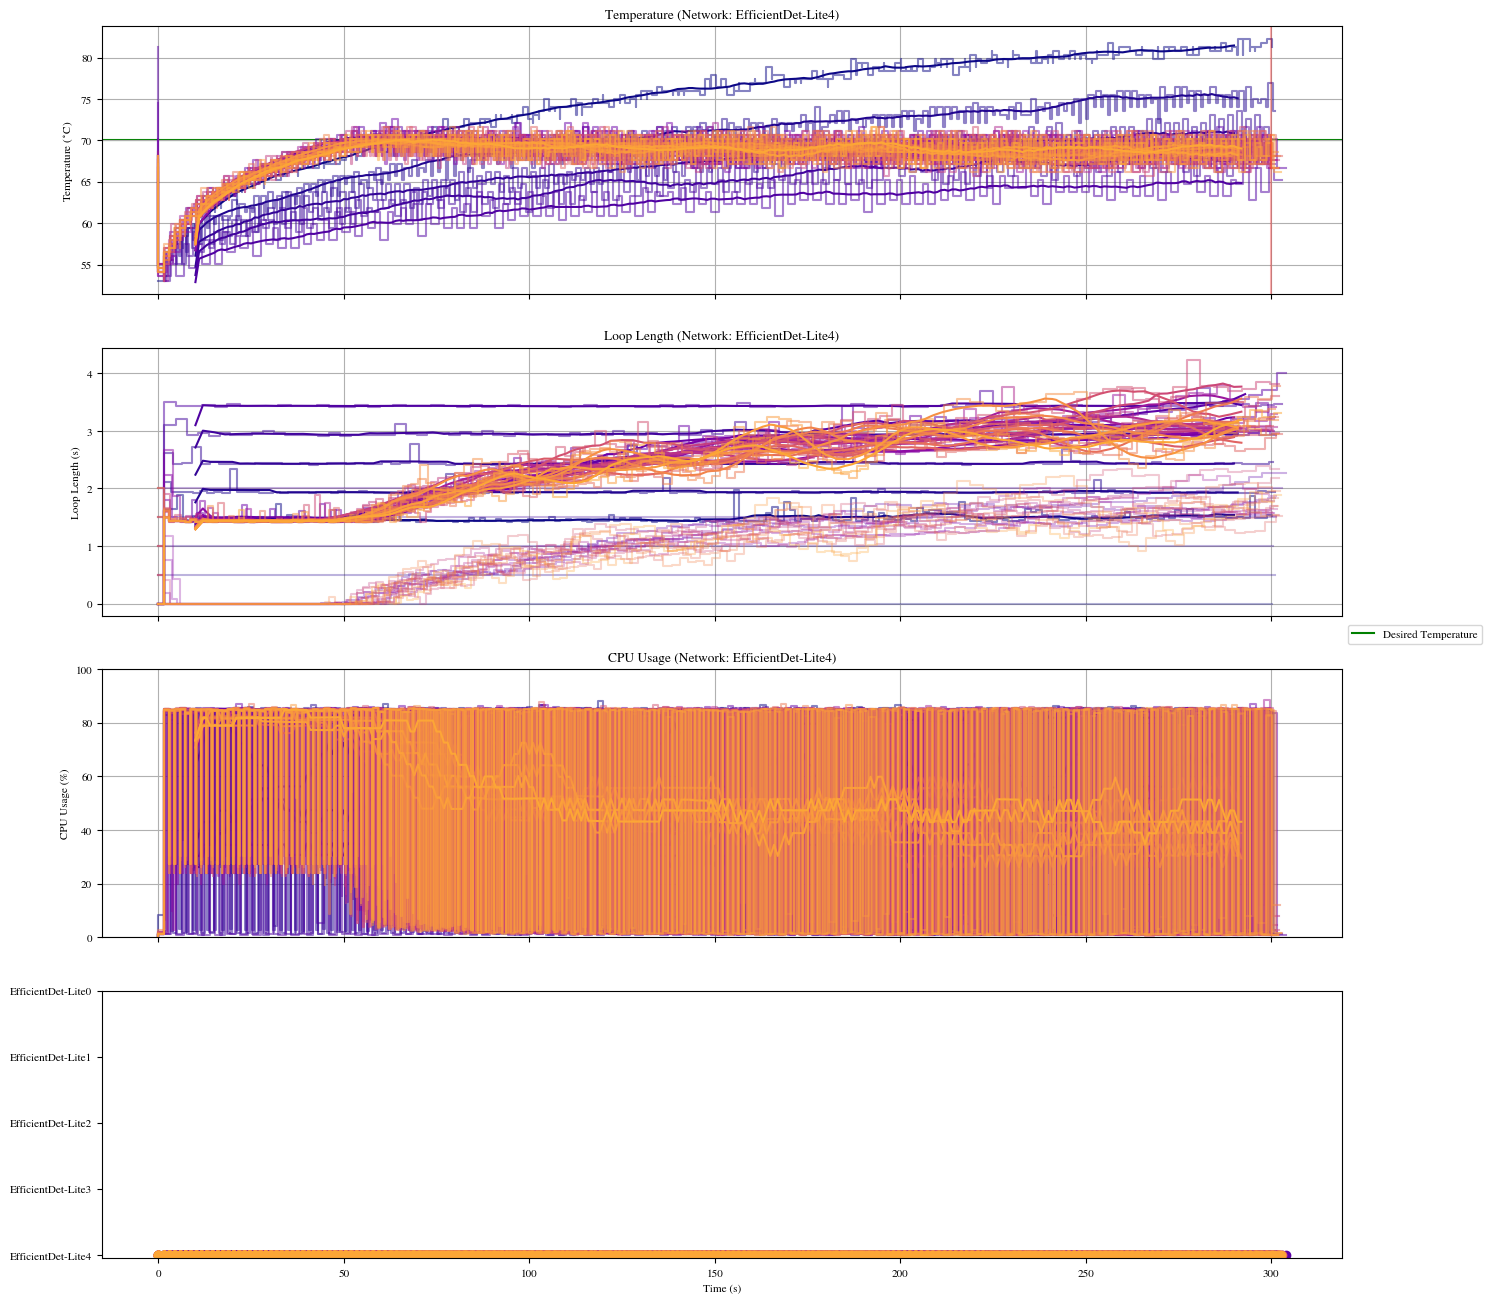

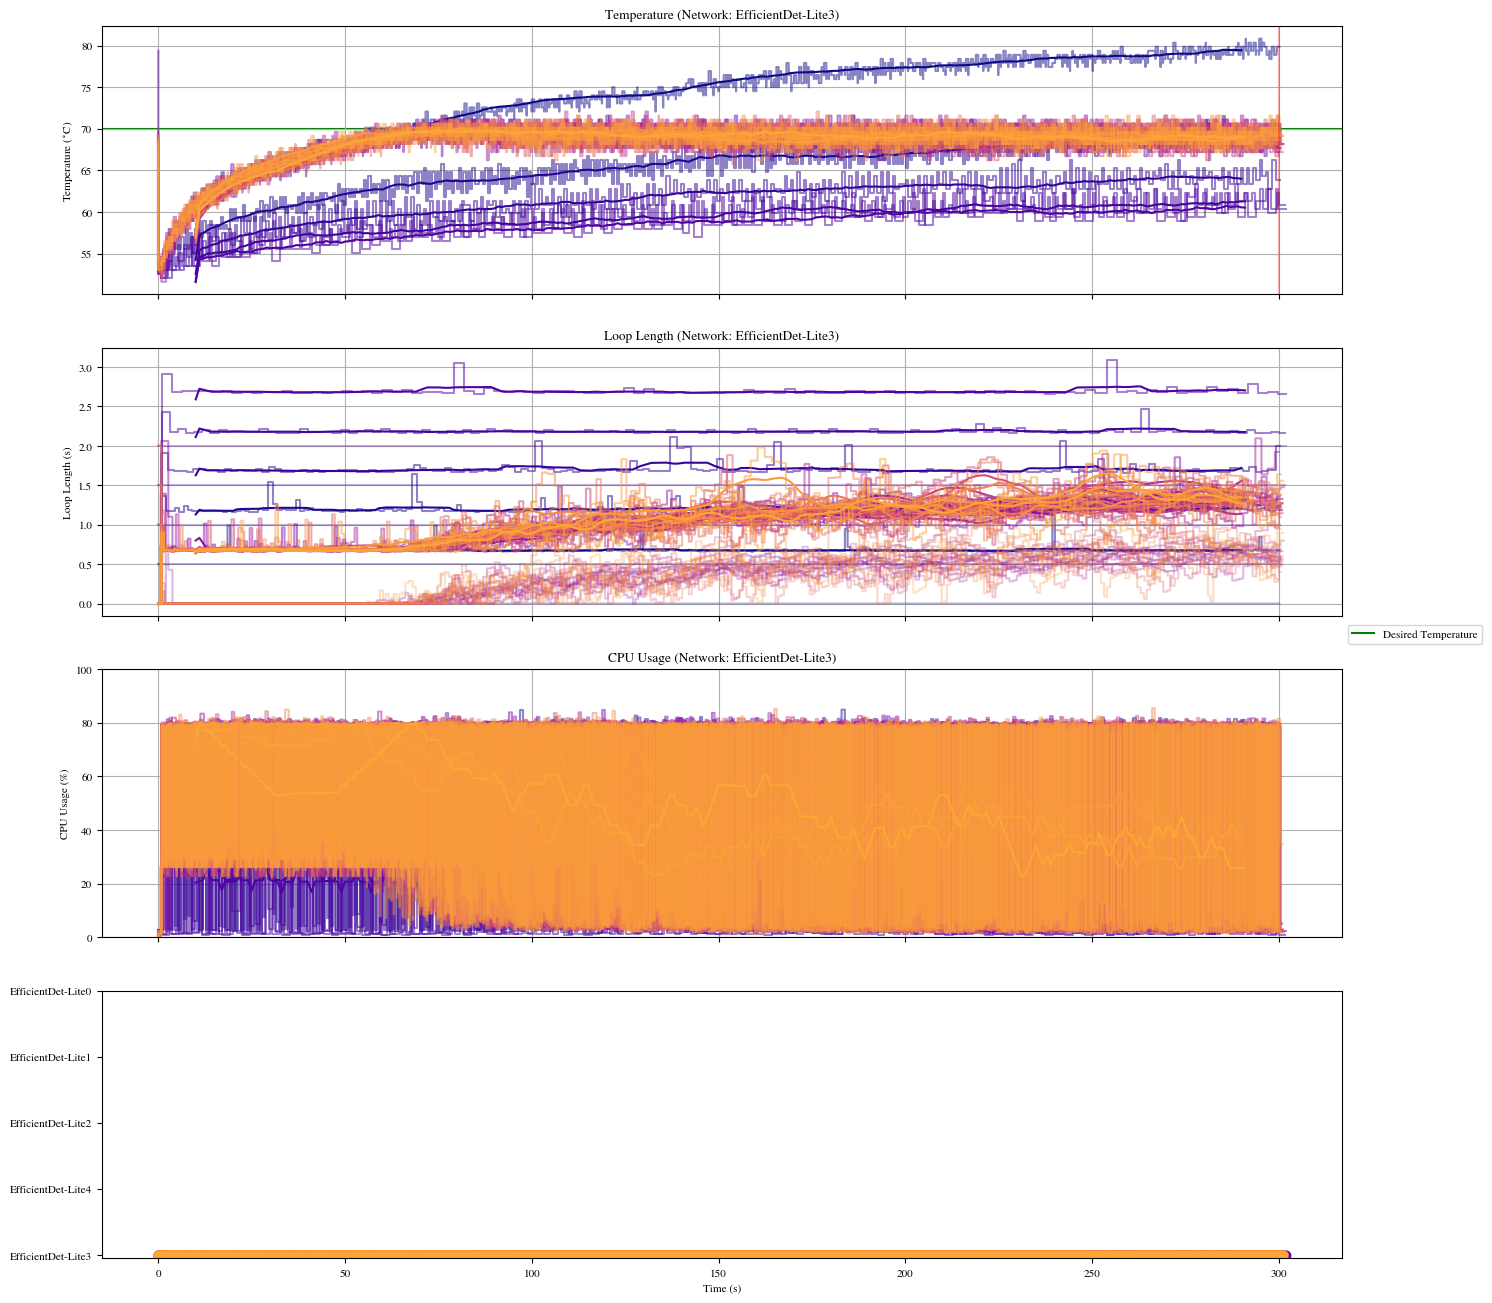

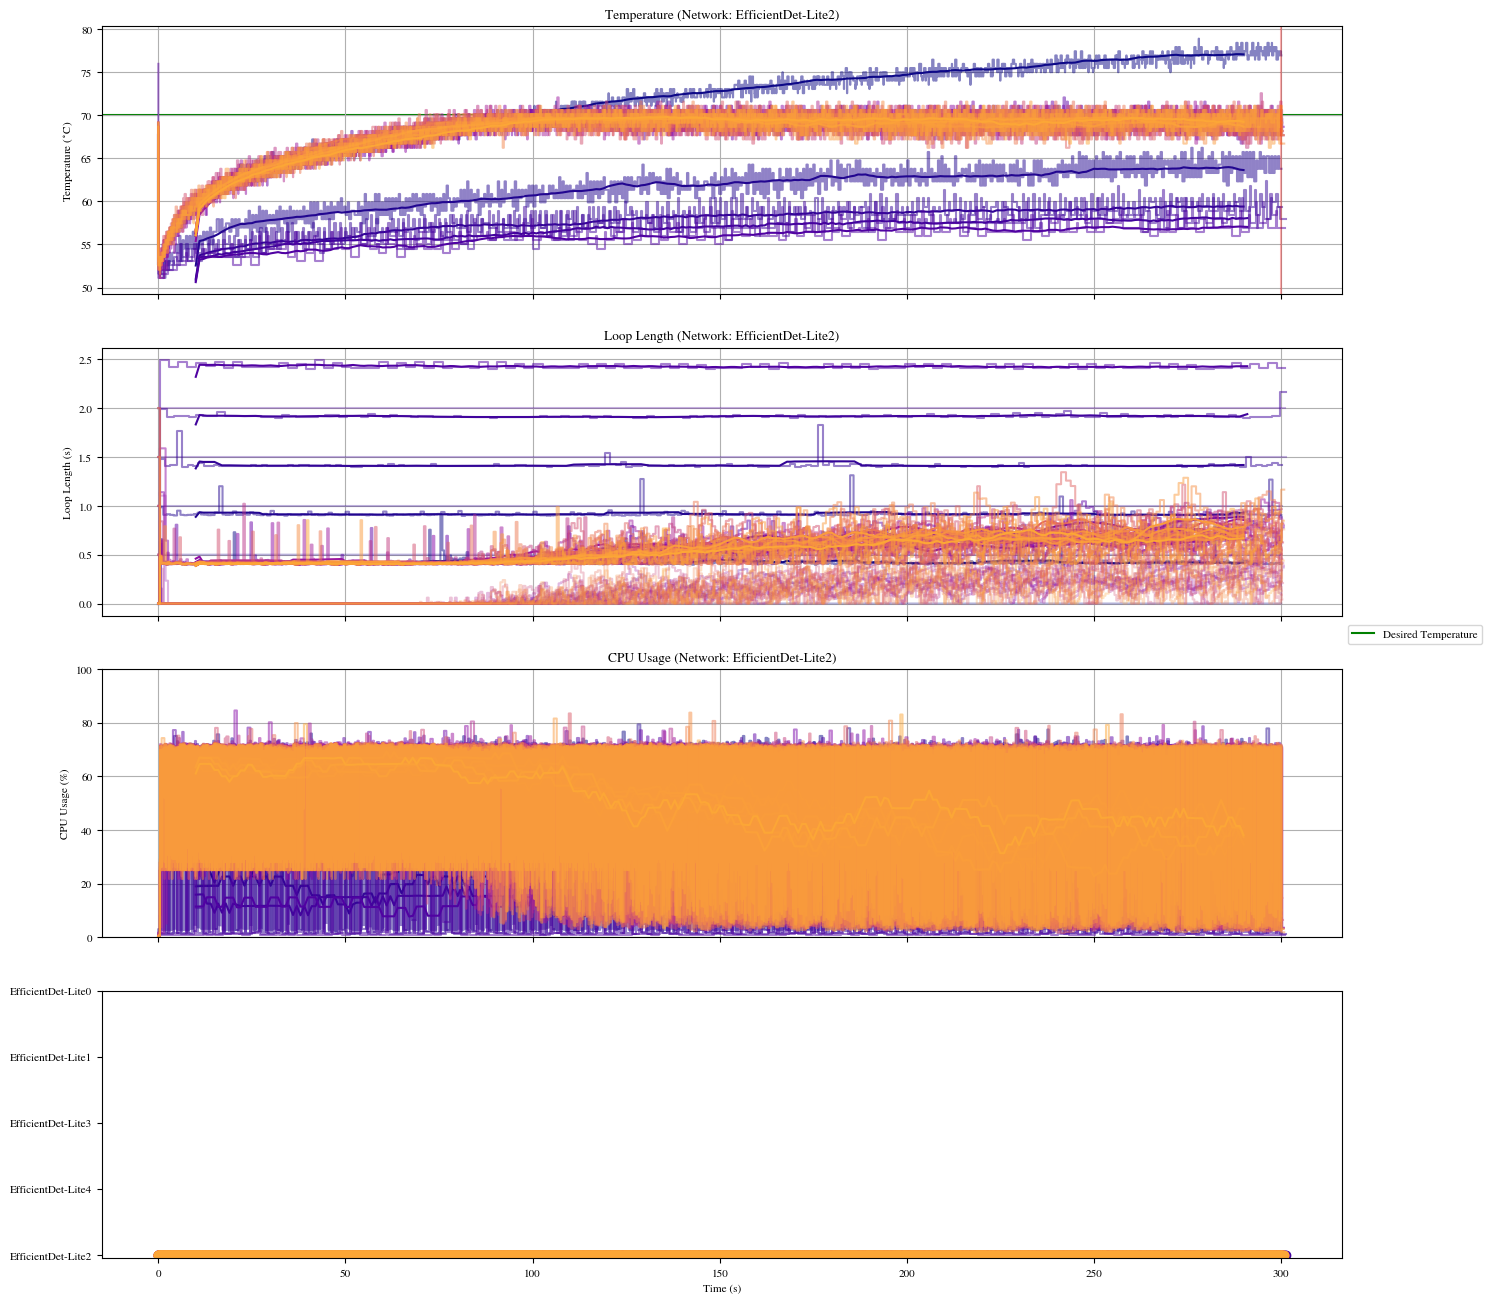

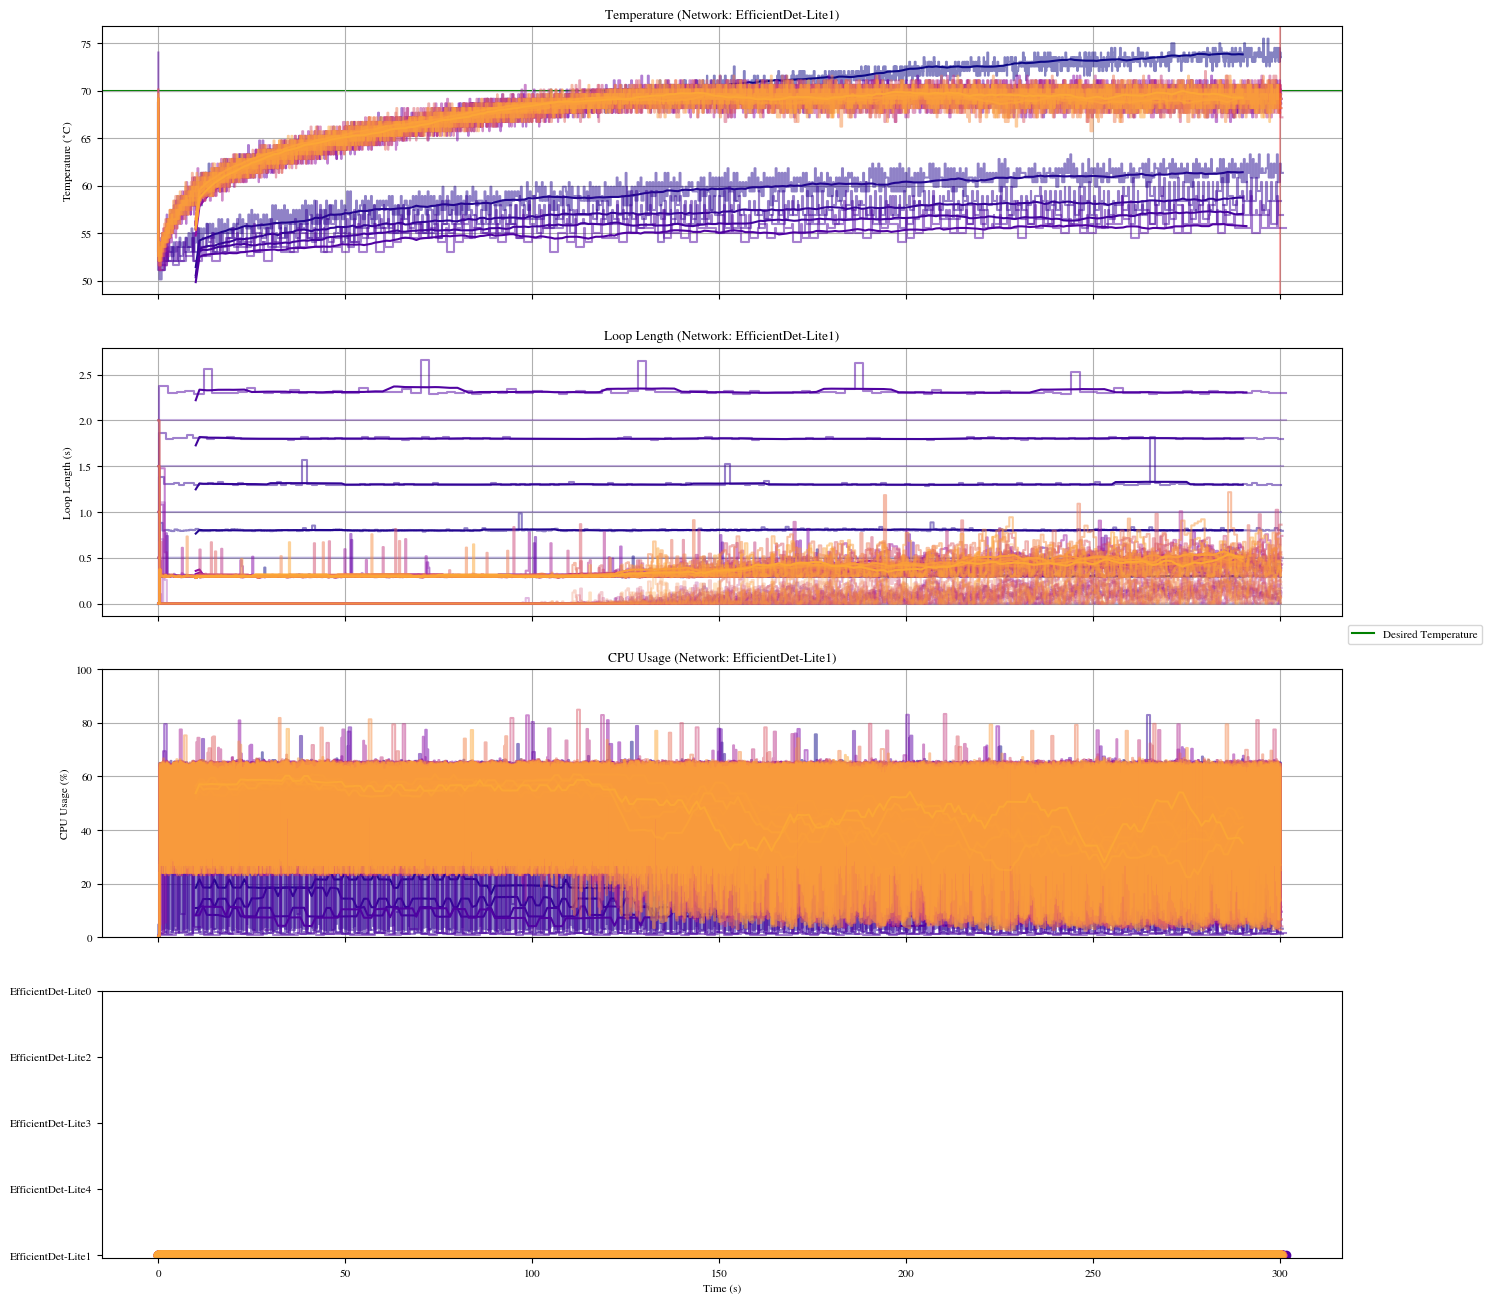

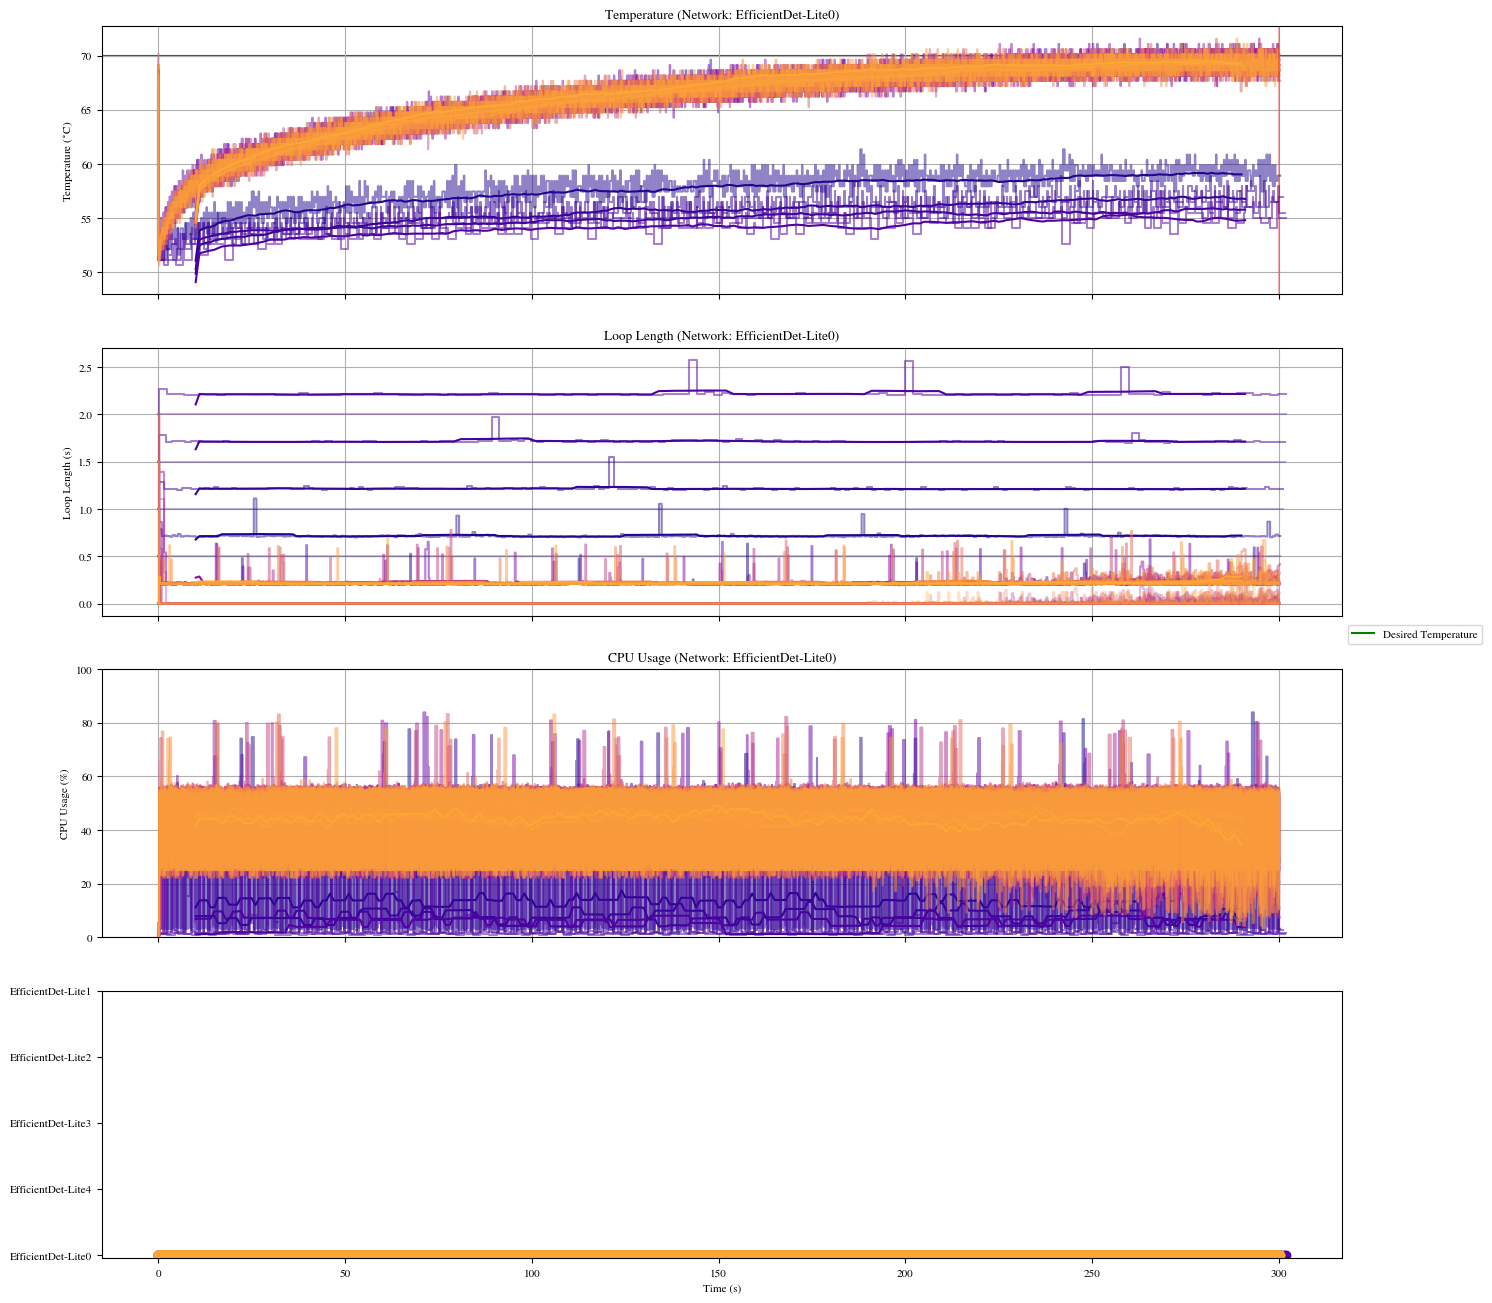

In [8]:
#-------------------------------------------------------------------
# Data Overview By Network for Algorithm 1
#-------------------------------------------------------------------

colors = cm.plasma(np.linspace(0, 0.8, len(PACs)*len(IPDs)))

if 'alg1' in ALGs:

    for k, net in enumerate(NETs) :

        fig, axs = plt.subplots(nrows=4,ncols=1, sharey='row', sharex='col')
        fig.set_figwidth(16)
        fig.set_figheight(16)
        net_name = net_names[k]

        for i, pac in enumerate(PACs) :
            for j, ipd in enumerate(IPDs) :

                iterator=j+i*len(IPDs)
                color = colors[iterator]

                working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]
                graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

                # Temperature

                axs[0].step(working_df['time_record'],working_df['temp_record_CPU'], 
                            # label="Test {} ; $p_a$: {} s /$^\circ$C ; $p_d$: {} s".format(j+i*num_pause_adjustment_coefficients+1, 
                            #                                           metadata['pause_adjustment_coef_records'][iterator],
                            #                                           metadata['initial_pause_duration_records'][iterator]),
                            color=color,
                            alpha=0.5
                           )

                axs[0].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2) +
                                  len(moving_average(graphing_temp,moving_average_window))),
                            moving_average(graphing_temp,moving_average_window),
                            # label= "Test {}; {} Second Average".format(j+i*num_pause_adjustment_coefficients+1,moving_average_window),
                            color=color,
                            alpha=1)

                # Loops

                axs[1].step(working_df['time_record'],
                            working_df['loop_duration_record'], 
                            color=color, 
                            alpha=0.5
                           )
                axs[1].step(working_df['time_record'],
                            working_df['pause_duration_record'], 
                            alpha=0.3,
                            color=color
                           )

                axs[1].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
                                  len(moving_average(graphing_loopLength,moving_average_window))),
                            moving_average(graphing_loopLength,moving_average_window), 
                            color=color,
                            alpha=1
                           )   

                # CPU
                axs[2].step(working_df['time_record'],working_df['cpu_record'],color=color,alpha=0.5)
                axs[2].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
                    len(moving_average(graphing_cpu,moving_average_window))),
                    moving_average(graphing_cpu,moving_average_window), color=color, alpha=1)

                axs[3].scatter(working_df['time_record'],working_df['net_record'], color=color)


        if device == 'nano' :
            axs[0].axhline(y=97, color='red',alpha=0.3,zorder=0)
            axs[0].set_ylim([50,100])

        elif device == 'rpi' :
            axs[0].axhline(y=80, color='red',alpha=0.3,zorder=0)
            axs[0].axhspan(80,85, color='red',alpha=0.1,label='Throttling Temperature',zorder=0)
            axs[0].axhline(y=85, color='red',alpha=0.3,zorder=0)
            axs[0].set_ylim([50,90])

        axs[0].axhline(y=threshold, color='green',alpha=1,label='Desired Temperature',zorder=0)
        axs[0].axvline(end_of_detections, color='red',alpha=0.3)
        axs[0].set_ylabel('Temperature ($^\circ$C)')
        axs[0].set_title('Temperature (Network: {})'.format(net_name))
        axs[0].grid()

        axs[1].set_ylabel('Loop Length (s)')
        axs[1].set_title('Loop Length (Network: {})'.format(net_name))
        axs[1].grid()

        axs[2].set_ylim([0,100])        
        axs[2].set_ylabel('CPU Usage (%)')
        axs[2].set_title('CPU Usage (Network: {})'.format(net_name))
        axs[2].grid()

        plt.sca(axs[3])
        ticks = NETs
        labels = net_names
        plt.yticks(ticks, labels)
        axs[3].set_xlabel('Time (s)')


        fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))

        # Save plot
        plot4_path = os.path.join(batch_path, "Combined__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot4_path,bbox_inches="tight",dpi=400)
        plot4_path = os.path.join(vis_path, "Combined__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot4_path,bbox_inches="tight",dpi=400)
        
    plt.show()

### Topology

In [ ]:
if 'alg1' in ALGs :
### Create Meta-result DF ###
    means ={}
    for net in NETs :
        mean_cpu = []
        mean_loop_duration = []
        mean_temp = []
        temp_error = []
        first_temp = []
        ipd_list = []
        pac_list = []
        for i, ipd in enumerate(IPDs) :
            for j, pac in enumerate(PACs) :
                # iterator = j+i*len(PACs)
                working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]
                mean_cpu.append(working_df['cpu_record'].mean())
                mean_loop_duration.append(working_df['loop_duration_record'].mean())
                mean_temp.append(working_df['temp_record_CPU'].mean())
                temp_error.append((working_df['temp_record_CPU'].sub(threshold)).pow(2).mean())
        #         first_temp.append(working_df['temp_record_CPU'][0])
                ipd_list.append(ipd)
                pac_list.append(pac)

        mean_record = {'mean_cpu':mean_cpu,
                       'mean_loop_duration':mean_loop_duration,
                       'mean_temp':mean_temp,
                       'temp_error':temp_error,
                       'ipd':ipd_list,
                       'pac':pac_list
        #                'first_temp':first_temp
                      }
        mean_df = pd.DataFrame.from_dict(mean_record)
        # means_df = metadata.join(mean_record_df)
        # mean_df['results'] = 10* (1/mean_df['mean_loop_duration']) * 1/(mean_df["mean_cpu"]/100) 
        # mean_df['
        means[net] = mean_df
        # means_and_meta_df

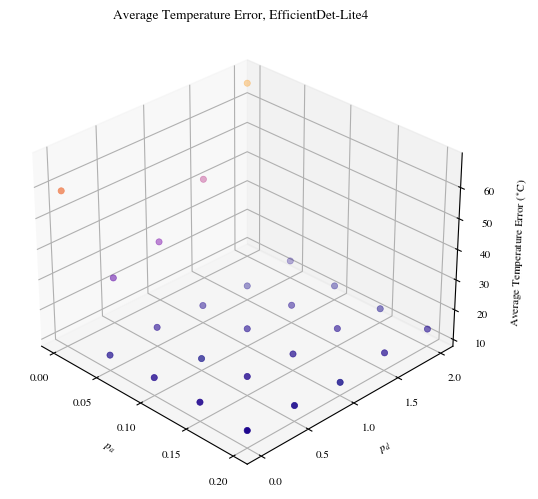

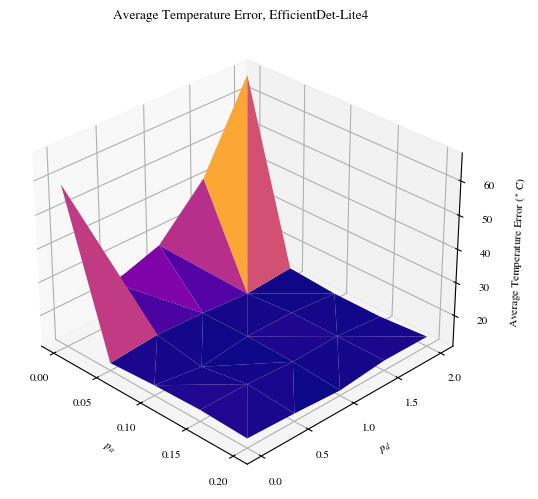

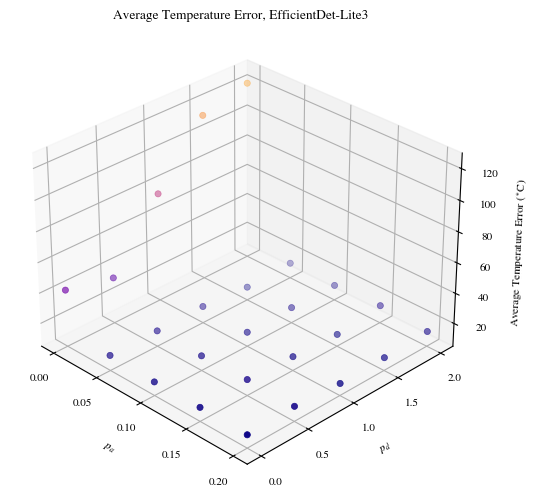

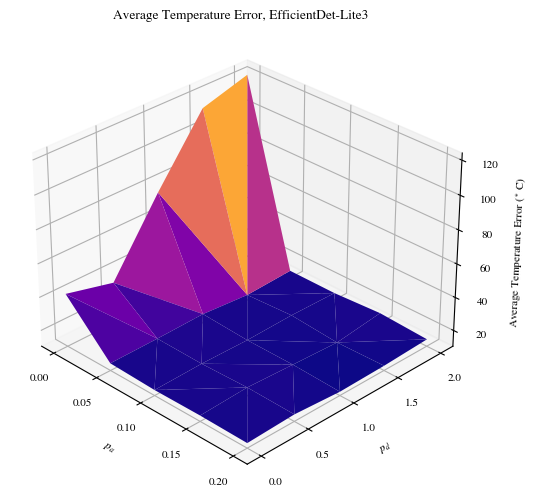

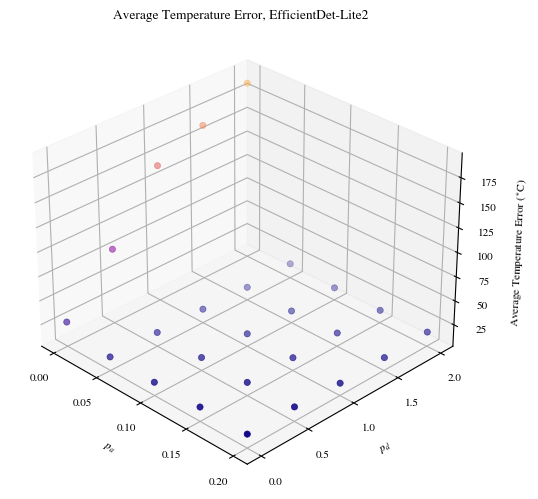

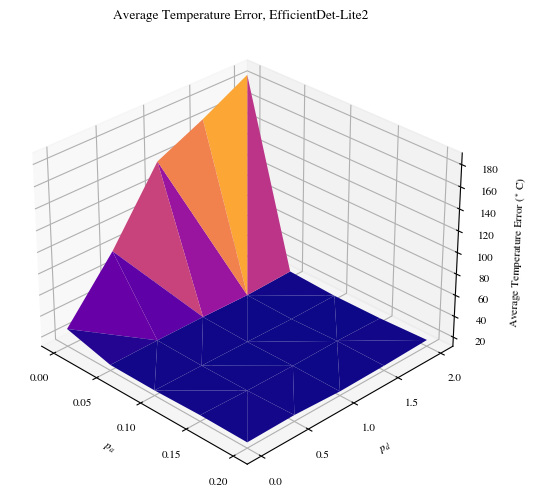

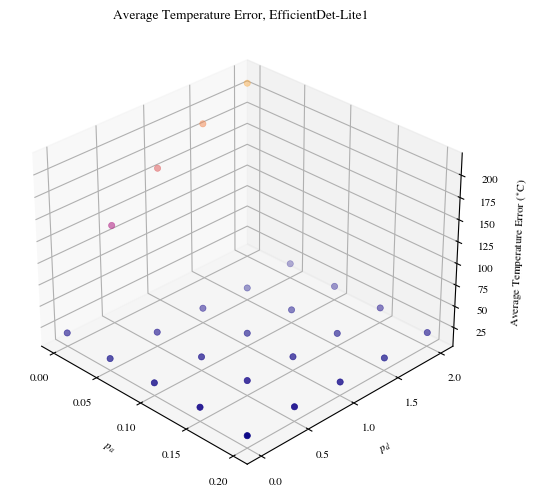

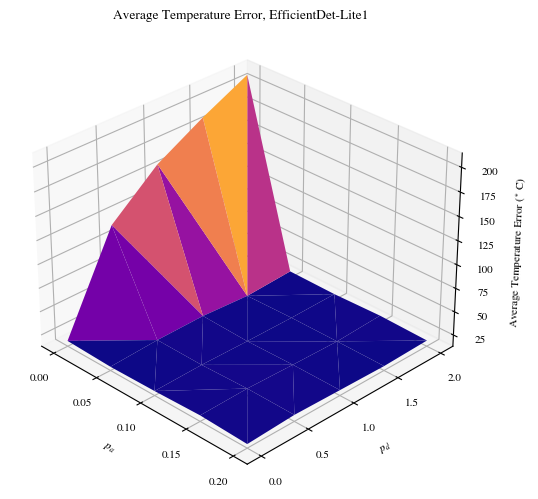

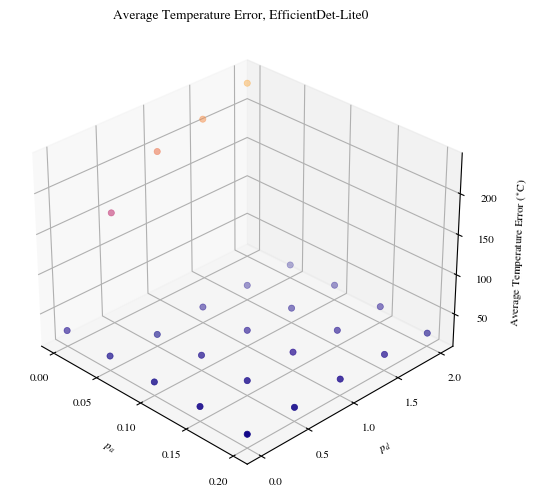

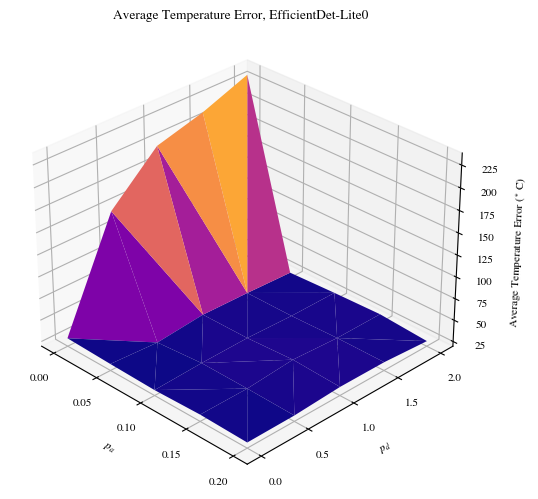

In [ ]:
if 'alg1' in ALGs :
    ### Mean Temp Topology ###
    for k, net in enumerate(NETs) :
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        
        net_name = net_names[k]

        y = means[net]['ipd'] # [means[net]['pac']>0]
        x = means[net]['pac'] # [means[net]['pac']>0]
        z = means[net]['temp_error'] # [means[net]['pac']>0]

        ax.scatter3D(x,y,z,c=z,cmap=working_plasma,linewidth=0.5)
        ax.set_ylabel('$p_d$')
        ax.set_xlabel('$p_a$')
        ax.set_zlabel('Average Temperature Error ($^\circ$C)')
        plt.yticks(np.linspace(0, max(y), len(IPDs)))
        plt.xticks(np.linspace(0, max(x), len(PACs)))
        ax.set_title('Average Temperature Error, {}'.format(net_name))
        ax.view_init(30, -45)

        plot_path = os.path.join(batch_path, "scatter__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        
        plot_path = os.path.join(vis_path, "scatter__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        # plt.show()

        fig = plt.figure(figsize=(6,6))

        ax = plt.axes(projection='3d')
        ax.plot_trisurf(x, y, z,cmap=working_plasma, edgecolor='none')
        ax.set_ylabel('$p_d$')
        ax.set_xlabel('$p_a$')
        ax.set_zlabel('Average Temperature Error ($^\circ$ C)')
        ax.set_title('Average Temperature Error, {}'.format(net_name))
        plt.yticks(np.linspace(0, max(y), len(IPDs)))
        plt.xticks(np.linspace(0, max(x), len(PACs)))
        ax.view_init(30, -45)


        plot_path = os.path.join(batch_path, "topology__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        plot_path = os.path.join(vis_path, "topology__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)

        plt.show()

### Efficiency

In [ ]:
# if program_name == ('Variable_Loop_V2' or 'Variable_Loop_V2_alg2') :

#     ### "Efficiency" ###

#     sns.heatmap(means_and_meta_df.corr())
#     plot9_path = os.path.join(batch_path, "mean_corr_heatmap_net_{}.png".format(net))
#     plt.savefig(plot9_path,bbox_inches="tight",dpi=400)
#     plt.show()

#     pivoted = means_and_meta_df.pivot('pause_adjustment_coef_records','initial_pause_duration_records','results')
#     pivoted = pivoted.T
#     axs = plt.axes()
#     sns.heatmap(pivoted,
#                 annot=True,
#                 cmap=working_plasma,
#                 fmt='.4g',
#                 cbar_kws={'label': '(10x) FPS per fraction of CPU use ',"orientation": "horizontal"}
#                )
#     axs.set_title('Image Processing Efficiency (Network: {})'.format(net))
#     axs.set_ylabel('Initial Loop Length [s]')
#     axs.set_xlabel('Loop Length Adjustment Coef. [s /$^\circ$C]')
#     plot10_path = os.path.join(batch_path, "results_net_{}.png".format(net))
#     plt.savefig(plot10_path,bbox_inches="tight",dpi=400)
#     plt.show()

### Temperature

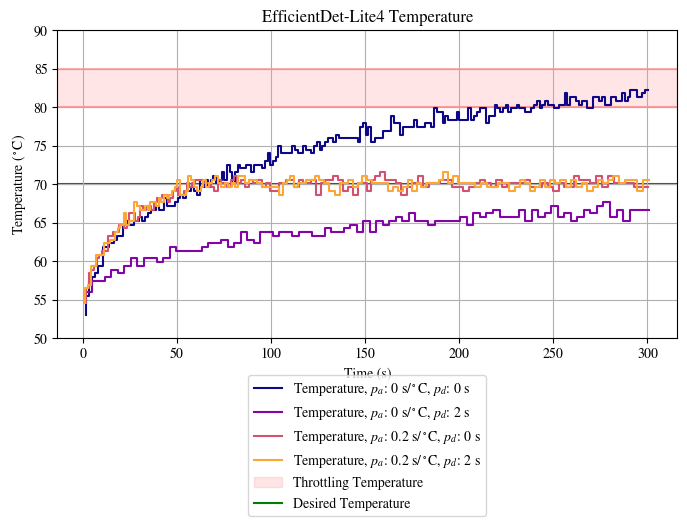

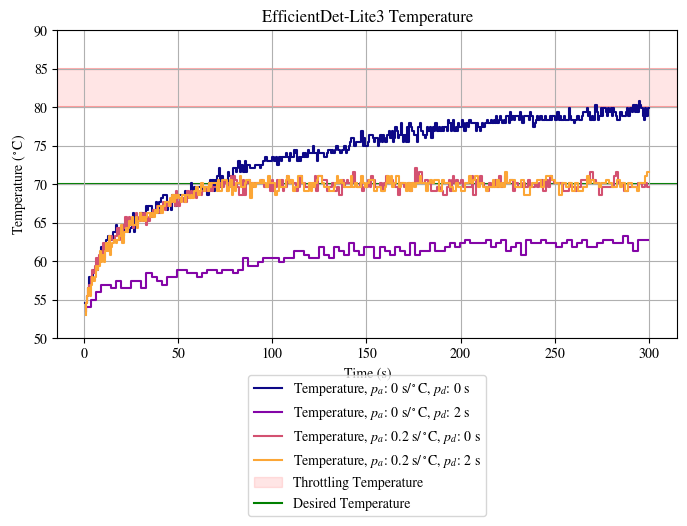

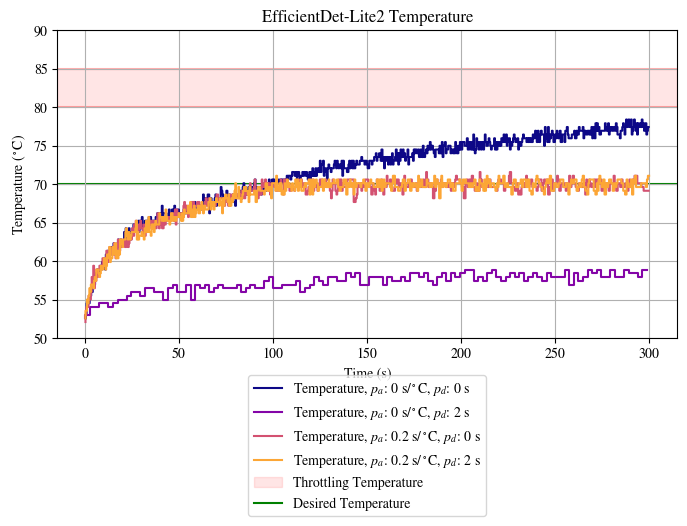

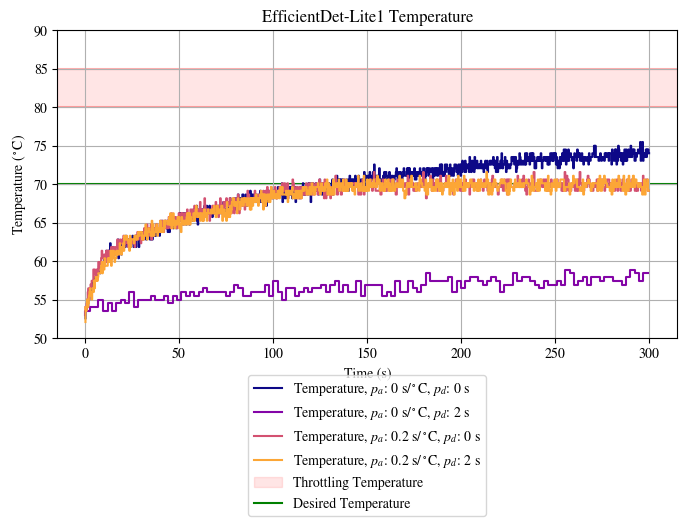

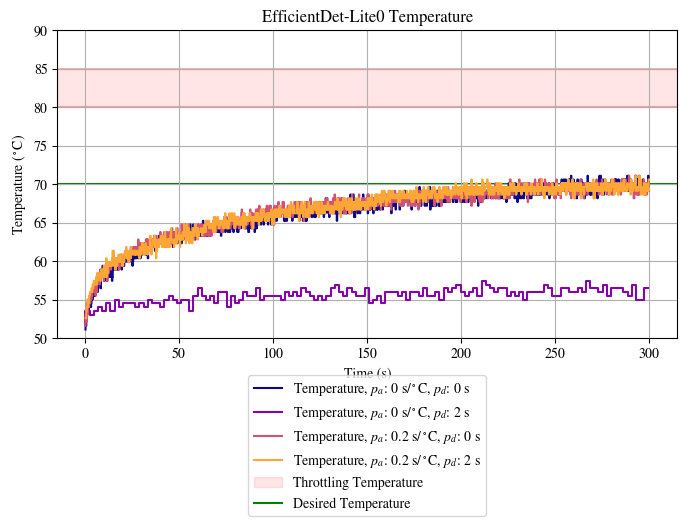

In [ ]:
### Temp v. Time (Paper) ###

colors = cm.plasma(np.linspace(0, 0.8, 4))

matplotlib.rcParams['font.size'] = 10

###################
### Algorithm 1 ###
###################
    
    
if 'alg1' in ALGs :
    for k, net in enumerate(NETs) :
        strat = 'N/A'
        TAC = 'N/A'
        net_name = net_names[k]
#         fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row')
#         fig.set_figwidth(fig_width)
#         fig.set_figheight(fig_height)
        
#         for i, pac in enumerate([0, 0.2]) :
#             for j, ipd in enumerate([0, 2]) :

#                 iterator = j + i*2
#                 zorder = iterator+5
#                 color = colors[iterator]

#                 working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]
#                 graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

#                 axs.step(working_df['time_record'],working_df['temp_record_CPU'], 
#                             label="Test {} ; $p_a$: {}s/$^\circ$C ; $p_d$: {}s".format(
#                                 iterator+1,
#                                 pac,
#                                 ipd),
#                             color=color,
#                             alpha=0.1,
#                             zorder=zorder
#                            )
#                 axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)
#                             + len(moving_average(graphing_temp,moving_average_window))),
#                             moving_average(graphing_temp,moving_average_window),
#                             color=color,
#         #                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
#                             label="Test {}, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
#                                 iterator+1,
#                                 pac,
#                                 ipd),                    
#                             alpha=1,
#                             zorder=zorder
#         #                     linewidth=
#                            )
#                 axs.step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
#                          color=color,
#                          alpha=0.2)
#                 axs.step(working_df[1:].iloc[1::2,:]['time_record'],working_df[1:].iloc[1::2,:]['temp_record_CPU'],
#                          color=color,
#                          alpha=0.2)

#         add_temperature_features()

#         # Save plot
#         plot_path = os.path.join(batch_path, "TempEffectOfMetareasoning_net_{}.png".format(net))
#         plt.savefig(plot_path,bbox_inches="tight",dpi=400)

        ## Clean
        fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
        fig.set_figwidth(fig_width)
        fig.set_figheight(fig_height)

        for i, pac in enumerate([0, 0.2]) :
            for j, ipd in enumerate([0, 2]) :

                iterator = j + i*2
                zorder = iterator+5
                color = colors[iterator]
                working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]

                plt.step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
                         color=color,
                         label="Temperature, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
                             pac,
                             ipd),                
                         alpha=1)

        add_temperature_features()
        axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6))

        # Save plot
        plot_path = os.path.join(batch_path, "CleanTempEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        plot_path = os.path.join(vis_path, "CleanTempEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)

    
# ###################
# ### Algorithm 2 ###
# ###################
            
# if 'alg2' in ALGs :
    
#      for k, strat in enumerate(STRATs) :
            
        
#         fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
#         fig.set_figwidth(fig_width)
#         fig.set_figheight(fig_height)
            
#         zorder = k+5
#         color = colors[0]

#         working_df = data[(data['alg']=='alg2') & (data['strat_record']==strat)]
#         net = 'Various'
#         TAC = 'N/A'
#         graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)


#         axs.step(working_df['time_record'],working_df['temp_record_CPU'], 
#                     label="Test {} ; $p_a$: {}s/$^\circ$C ; $p_d$: {}s".format(
#                         iterator+1,
#                         pac,
#                         ipd),
#                     color=color,
#                     alpha=0.1,
#                     zorder=zorder
#                    )
#         axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)
#                     + len(moving_average(graphing_temp,moving_average_window))),
#                     moving_average(graphing_temp,moving_average_window),
#                     color=color,
# #                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
#                     label="Test {}, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
#                         iterator+1,
#                         pac,
#                         ipd),                    
#                     alpha=1,
#                     zorder=zorder
# #                     linewidth=
#                    )
#         axs.step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
#                  color=color,
#                  alpha=0.2)
#         axs.step(working_df[1:].iloc[1::2,:]['time_record'],working_df[1:].iloc[1::2,:]['temp_record_CPU'],
#                  color=color,
#                  alpha=0.2)

#         add_temperature_features()

#         # Save plot
#         plot11_path = os.path.join(batch_path, "TempEffectOfMetareasoning_strat_{}.png".format(strat))
#         plt.savefig(plot11_path,bbox_inches="tight",dpi=400)

#         ## Clean
#         fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
#         fig.set_figwidth(fig_width)
#         fig.set_figheight(fig_height)

#         zorder = k+5
#         color = colors[0]
#         working_df = data[(data['alg']=='alg2') & (data['strat_record']==strat)]

#         plt.step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
#                  color=color,
#                  label="Test {}, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
#                      iterator+1,
#                      pac,
#                      ipd),                
#                  alpha=1)

#         add_temperature_features()

#         # Save plot
#         plot11_path = os.path.join(batch_path, "CleanTempEffectOfMetareasoning_strat_{}.png".format(strat))
#         plt.savefig(plot11_path,bbox_inches="tight",dpi=400)



# ###################
# ### Algorithm 3 ###
# ###################
    
# ## Switching
# if 'alg3' in ALGs :
#     for k, strat in enumerate(STRATs) :
#         for h, TAC in enumerate(TACs) :
            
#             net = 'Various'
#             fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
#             fig.set_figwidth(fig_width)
#             fig.set_figheight(fig_height)
            
#             iterator = h + i * len(TACs)
#             zorder = iterator+5
#             color = colors[0]
#             working_df = data[(data['alg']=='alg3') & (data['strat_record']==strat) & (data['TAC_record']==TAC)]

#             plt.step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
#                      color=color,
#                      label="Algorithm 3 Test",                
#                      alpha=1)

#             add_temperature_features()

#             # Save plot
#             plot11_path = os.path.join(batch_path, "SwitchingTempEffectOfMetareasoning_strat_{}_TAC_{}.png".format(strat, TAC))
#             plt.savefig(plot11_path,bbox_inches="tight",dpi=400)

plt.show()

### Loop

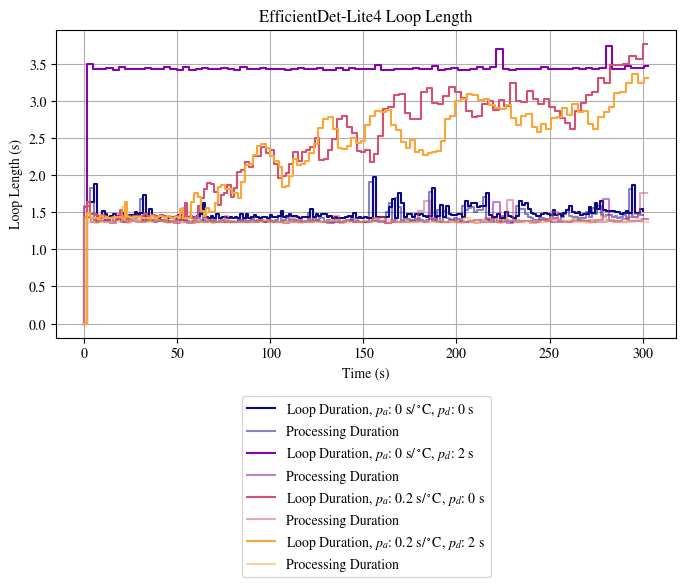

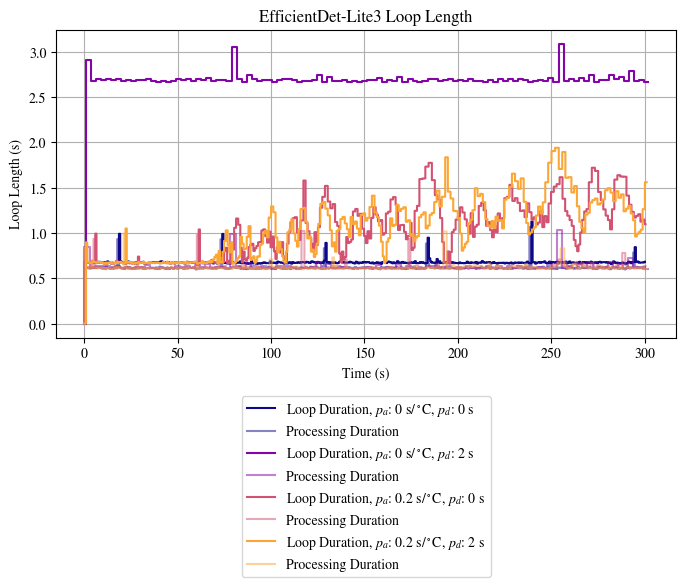

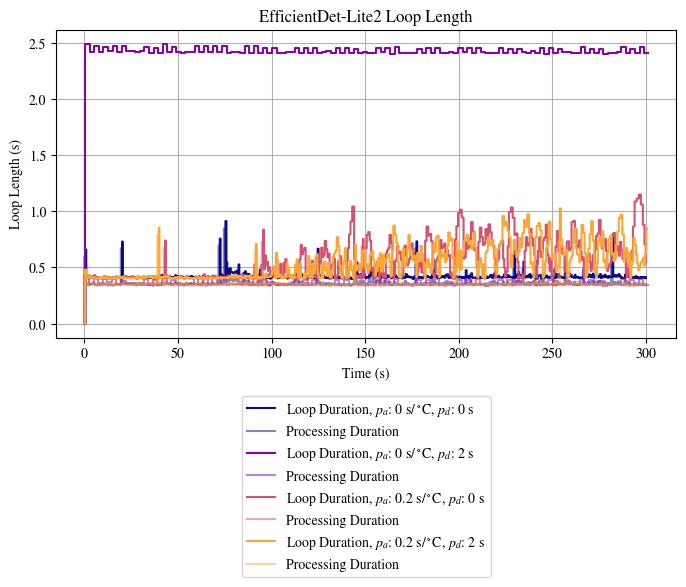

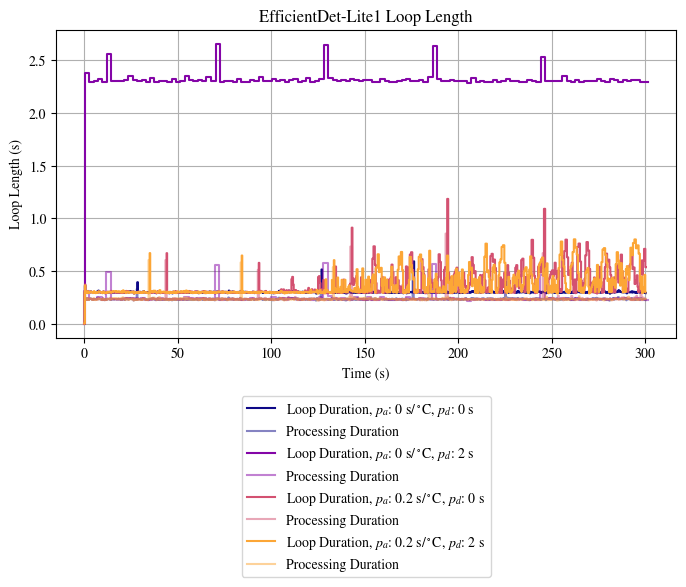

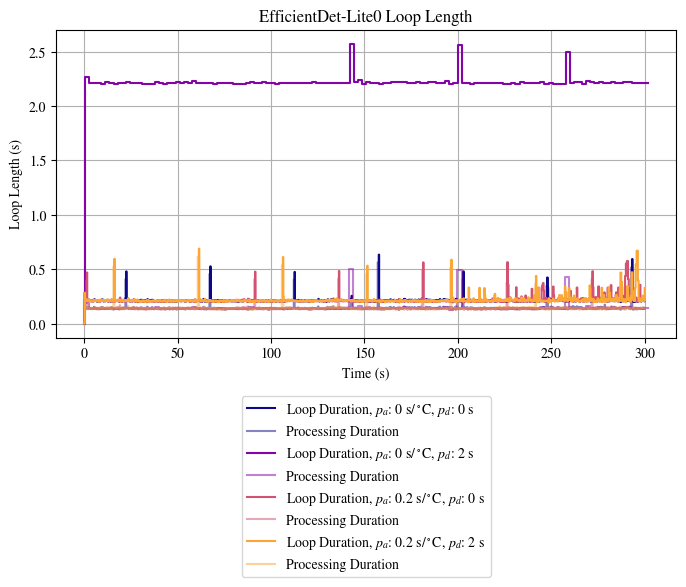

In [44]:
### Loop v. Time (Paper) ###


###################
### Algorithm 1 ###
###################

if 'alg1' in ALGs :
    
    for k, net in enumerate(NETs) :
    
        strat = 'N/A'
        TAC = 'N/A'
        net_name = net_names[k]
        
        colors = cm.plasma(np.linspace(0, 0.8, 4))
        fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
        fig.set_figwidth(fig_width)
        fig.set_figheight(fig_height)
        temp = []
        count = 0

        for i, pac in enumerate([0, 0.2]) :
            for j, ipd in enumerate([0, 2]) :

                iterator = j + i*2
                zorder = iterator+5
                color = colors[iterator]

                working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]
                graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)


                axs.step(working_df['time_record'], 
                         working_df['loop_duration_record'],
                         color=color, 
                         alpha=1,
                         zorder=zorder,
                         label="Loop Duration, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
                             pac,
                             ipd)                 
                        )      

        #         axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
        #                           len(moving_average(graphing_loopLength,moving_average_window))),
        #                        moving_average(graphing_loopLength,moving_average_window), 
        #                  color=color,
        #                  alpha=1,
        #                  label="Test {} ; $p_a$: {} s /$^\circ$C ; $p_d$: {} s".format(
        #                      iterator+1,
        #                      metadata['pause_adjustment_coef_records'][iterator],
        #                      metadata['initial_pause_duration_records'][iterator])
        #                    )   

                # axs.step(working_df['time_record'], working_df['pause_duration_record'], 
                #             alpha=0.5,
                #             color=color,
                #             zorder=zorder,
                #             label= "Pause Duration",
                #            )  
                axs.step(working_df['time_record'], working_df['processing_duration_record'], 
                            alpha=0.5,
                            color=color,
                            zorder=zorder,
                            label= "Processing Duration",
                           )
            

                count +=1

        add_loop_features()
        axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))


        # Save plot
        plot_path = os.path.join(batch_path, "LoopEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)

        plot_path = os.path.join(vis_path, "LoopEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
    
# ###################
# ### Algorithm 2 ###
# ###################

# if program_name == 'Variable_Loop_V2_alg2' :
#     for i in tqdm.notebook.tnrange(0,1,leave=False) :
#         for j in tqdm.notebook.tnrange(0,1,leave=False) :

#             iterator = j+i*num_pause_adjustment_coefficients
#             zorder = iterator
#             color = colors[count]

#             working_df = df[iterator]
#             graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

#             axs.step(working_df['time_record'], 
#                      working_df['loop_duration_record'],
#                      color=color, 
#                      alpha=1,
#                      zorder=zorder,
#                      label="Test {}, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
#                          iterator+1,
#                          metadata['pause_adjustment_coef_records'][iterator],
#                          metadata['initial_pause_duration_records'][iterator])                 
#                     )      

#     #         axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#     #                           len(moving_average(graphing_loopLength,moving_average_window))),
#     #                        moving_average(graphing_loopLength,moving_average_window), 
#     #                  color=color,
#     #                  alpha=1,
#     #                  label="Test {} ; $p_a$: {} s /$^\circ$C ; $p_d$: {} s".format(
#     #                      iterator+1,
#     #                      metadata['pause_adjustment_coef_records'][iterator],
#     #                      metadata['initial_pause_duration_records'][iterator])
#     #                    )   

#             axs.step(working_df['time_record'], working_df['pause_duration_record'], 
#                         alpha=0.5,
#                         color=color,
#                         zorder=zorder,
#                         label= "Test {}, Pause Duration".format(iterator+1),
#                        )  

#             count +=1

#     add_loop_features()

#     # Save plot
#     plot12_path = os.path.join(batch_path, "LoopEffectOfMetareasoning_net_{}.png".format(net))
#     plt.savefig(plot12_path,bbox_inches="tight",dpi=400)

    
    
# ###################
# ### Algorithm 3 ###
# ###################

# ## Switching

# if program_name == 'Combined' :
#     for i in tqdm.notebook.tnrange(0,1,leave=False) :
#         for j in tqdm.notebook.tnrange(0,1,leave=False) :

#             iterator = j+i*num_pause_adjustment_coefficients
#             zorder = iterator
#             color = colors[count]

#             working_df = df[iterator]
#             graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

#             axs.step(working_df['time_record'], 
#                      working_df['loop_duration_record'],
#                      color=color, 
#                      alpha=1,
#                      zorder=zorder,
#                      label="Algorithm 2 Test"                
#                     )      

#     #         axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#     #                           len(moving_average(graphing_loopLength,moving_average_window))),
#     #                        moving_average(graphing_loopLength,moving_average_window), 
#     #                  color=color,
#     #                  alpha=1,
#     #                  label="Test {} ; $p_a$: {} s /$^\circ$C ; $p_d$: {} s".format(
#     #                      iterator+1,
#     #                      metadata['pause_adjustment_coef_records'][iterator],
#     #                      metadata['initial_pause_duration_records'][iterator])
#     #                    )   

#             axs.step(working_df['time_record'], working_df['pause_duration_record'], 
#                         alpha=0.5,
#                         color=color,
#                         zorder=zorder,
#                         label= "Pause Duration"
#                        )  

#             count +=1

#     add_loop_features()

#     # Save plot
#     plot12_path = os.path.join(batch_path, "SwitchingLoopEffectOfMetareasoning_net_{}.png".format(net))
#     plt.savefig(plot12_path,bbox_inches="tight",dpi=400)

        plt.show()

### CPU 

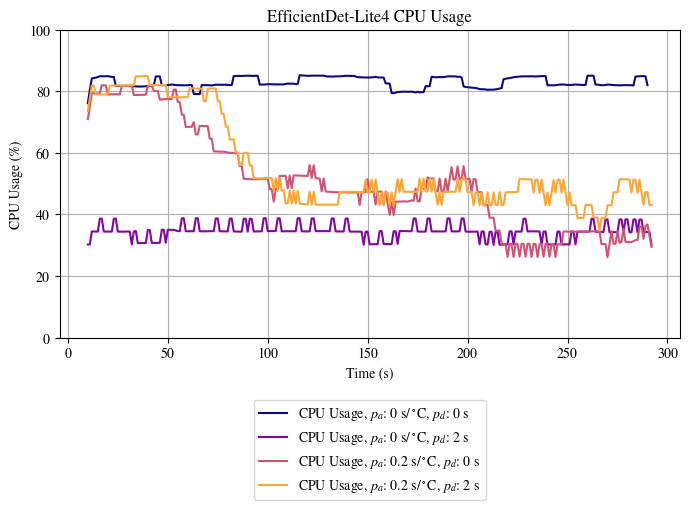

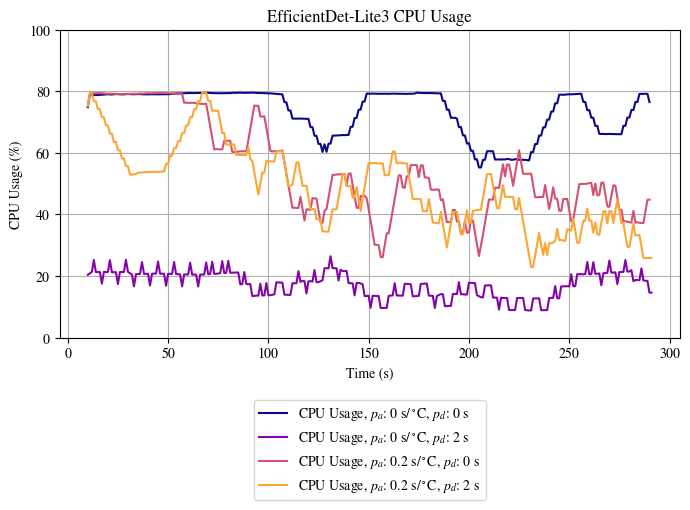

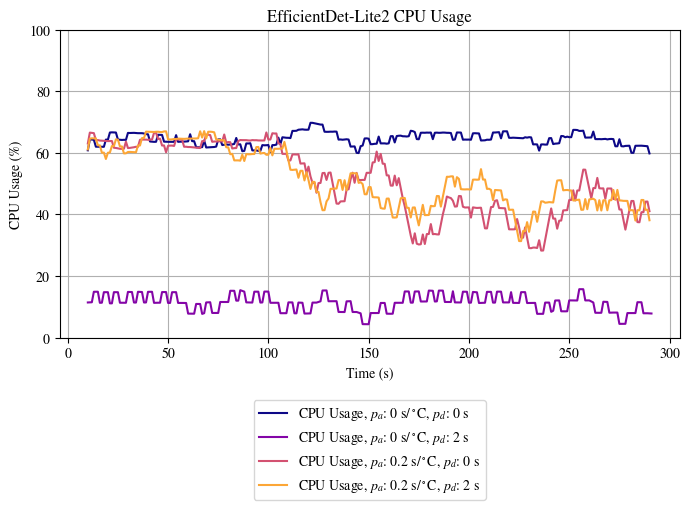

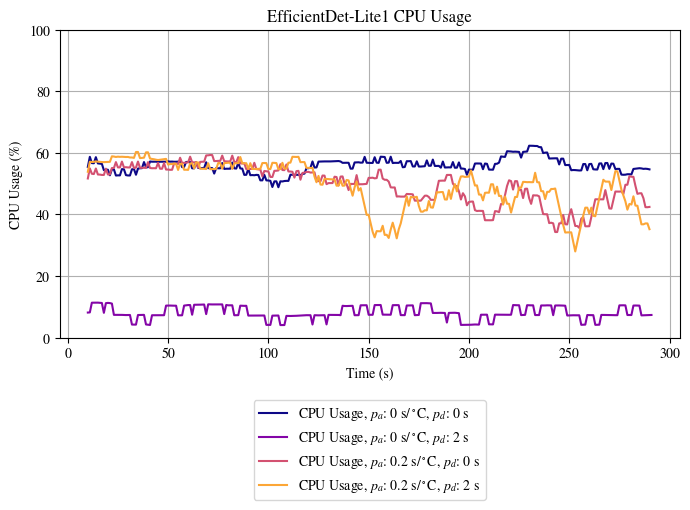

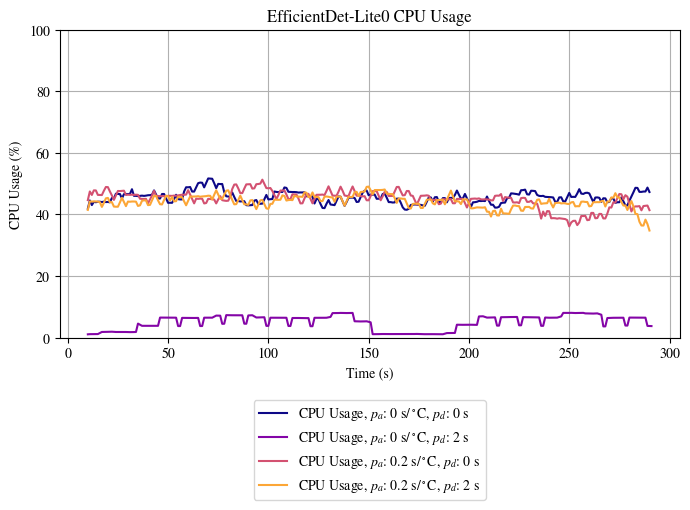

In [ ]:
### CPU v. Time (Paper) ###

colors = cm.plasma(np.linspace(0, 0.8, 4))

###################
### Algorithm 1 ###
###################
if 'alg1' in ALGs :
    for k, net in enumerate(NETs) :

        fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
        fig.set_figwidth(fig_width)
        fig.set_figheight(fig_height)
        
        strat = 'N/A'
        TAC = 'N/A'
        net_name = net_names[k]

        for i, pac in enumerate([0, 0.2]) :
            for j, ipd in enumerate([0, 2]) :

                iterator = j + i*2
                zorder = iterator+5
                color = colors[iterator]

                working_df = data[(data['alg']=='alg1') & (data['pause_adjustment_coef_records']==pac) & (data['initial_pause_duration_records']==ipd) & (data['start_net']==net)]
                graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

    #         axs.step(working_df['time_record'],working_df['cpu_record'],
    #                     color=color,
    #                     alpha=0.05,
    #                     zorder=zorder,
    # #                     label="Test {} ; $p_a$: {}$/degree$C ; $p_d$: {}s".format(
    # #                         iterator+1,
    # #                         metadata['pause_adjustment_coef_records'][iterator],
    # #                         metadata['initial_pause_duration_records'][iterator]),
    #                    )
                axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
                            len(moving_average(graphing_cpu,moving_average_window))),
                            moving_average(graphing_cpu,moving_average_window), 
                            color=color, 
                            alpha=1,
                            zorder=zorder,
        #                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
                            label="CPU Usage, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
                                pac,
                                ipd),                    
                       )
            # count += 1

        add_cpu_features()
        axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55))

        # Save plot
        plot_path = os.path.join(batch_path, "CPUEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        plot_path = os.path.join(vis_path, "CPUEffectOfMetareasoning__device_{}__net_{}.png".format(device, net_name))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)


# ###################
# ### Algorithm 2 ###
# ###################

# if program_name == 'Variable_Loop_V2_alg2' :
#     for i in tqdm.notebook.tnrange(0,1,leave=False) :
#         for j in tqdm.notebook.tnrange(0,1,leave=False) :
#             iterator = j+i*num_pause_adjustment_coefficients
#             zorder = iterator
#             color = colors[count]

#             working_df = df[iterator]
#             graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

#     #         axs.step(working_df['time_record'],working_df['cpu_record'],
#     #                     color=color,
#     #                     alpha=0.05,
#     #                     zorder=zorder,
#     # #                     label="Test {} ; $p_a$: {}$/degree$C ; $p_d$: {}s".format(
#     # #                         iterator+1,
#     # #                         metadata['pause_adjustment_coef_records'][iterator],
#     # #                         metadata['initial_pause_duration_records'][iterator]),
#     #                    )
#             axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#                         len(moving_average(graphing_cpu,moving_average_window))),
#                         moving_average(graphing_cpu,moving_average_window), 
#                         color=color, 
#                         alpha=1,
#                         zorder=zorder,
#     #                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
#                         label="Test {}, $p_a$: {} s/$^\circ$C, $p_d$: {} s".format(
#                             iterator+1,
#                             metadata['pause_adjustment_coef_records'][iterator],
#                             metadata['initial_pause_duration_records'][iterator]),                    
#                        )
#             count += 1

#     add_cpu_features()

#     # Save plot
#     plot13_path = os.path.join(batch_path, "CPUEffectOfMetareasoning_net_{}.png".format(net))
#     plt.savefig(plot13_path,bbox_inches="tight",dpi=400)



# ###################
# ### Algorithm 3 ###
# ###################

# ## Switching
# if program_name == 'Combined' :

#     for i in tqdm.notebook.tnrange(0,1,leave=False) :
#         for j in tqdm.notebook.tnrange(0,1,leave=False) :
#             iterator = j+i*num_pause_adjustment_coefficients
#             zorder = iterator
#             color = colors[count]

#             working_df = df[iterator]
#             graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

#     #         axs.step(working_df['time_record'],working_df['cpu_record'],
#     #                     color=color,
#     #                     alpha=0.05,
#     #                     zorder=zorder,
#     # #                     label="Test {} ; $p_a$: {}$/degree$C ; $p_d$: {}s".format(
#     # #                         iterator+1,
#     # #                         metadata['pause_adjustment_coef_records'][iterator],
#     # #                         metadata['initial_pause_duration_records'][iterator]),
#     #                    )
#             axs.plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#                         len(moving_average(graphing_cpu,moving_average_window))),
#                         moving_average(graphing_cpu,moving_average_window), 
#                         color=color, 
#                         alpha=1,
#                         zorder=zorder,
#     #                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
#                         label="Algorithm 2 Test"                    
#                        )
#             count += 1

#     add_cpu_features()

#     # Save plot
#     plot13_path = os.path.join(batch_path, "SwitchingCPUEffectOfMetareasoning_net_{}.png".format(net))
#     plt.savefig(plot13_path,bbox_inches="tight",dpi=400)

plt.show()

## Algs 2 and 3 

### Overview

KeyError: 'strat_record'

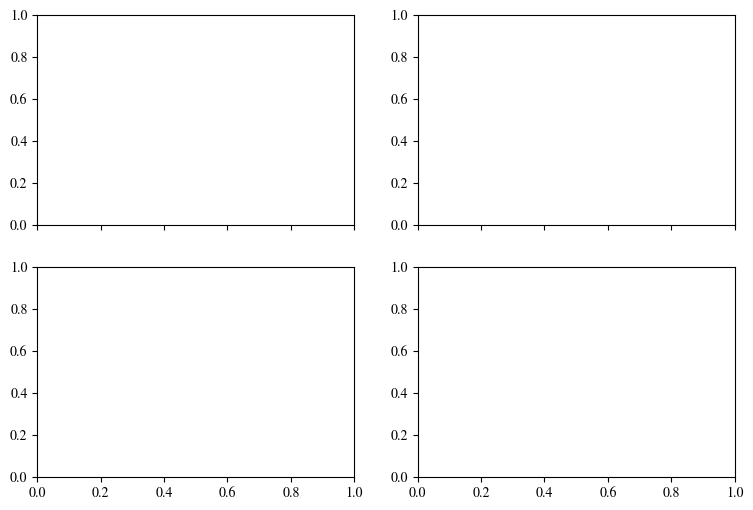

In [ ]:
#
# Me trying to make a visual that won't melt my brain
#

# matplotlib.rcParams['font.size'] = 8

if 'alg2' and 'alg3' or 'alg4' in ALGs :
    zorder = 0
    colors = cm.plasma(np.linspace(0, 0.8, 5))
    # dev = pd.unique(data['test_number'][(data['strat_record']==1)])
    for test in TESTs :
        fig, axs = plt.subplots(nrows=2,ncols=2, sharex='col')
        fig.set_figwidth(9)
        fig.set_figheight(6)
        color = colors[0]
        working_df = data[data['test_number']==test]
        if working_df['strat_record'].isnull().values.any() :
            strat = 'NA'
            TAC = 'NA'
            net = net_dict[pd.unique(working_df['start_net'].dropna())[0]]
            pac = pd.unique(working_df['pause_adjustment_coef_records'].dropna())[0]
            ipd = pd.unique(working_df['initial_pause_duration_records'].dropna())[0]
        else :
            strat = int(pd.unique(working_df['strat_record'].dropna())[0])
            net = 'Various'
            ipd = 0
            pac = 0.2
            if working_df['TAC_record'].isnull().values.any() :
                TAC = 'NA'
            else : 
                TAC = int(pd.unique(working_df['TAC_record'].dropna())[0])

        # strat = 'NA'
        # TAC = 'NA'
        pac = '0.2'

        graphing_temp, graphing_cpu, graphing_loopLength = generate_graphing_data(working_df)

        # Temperature
        axs[0,0].step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_CPU'],
                 color=color,                
                 alpha=1)
        # axs[0,0].step(working_df[1:].iloc[0::2,:]['time_record'],working_df[1:].iloc[0::2,:]['temp_record_GPU'],
        #          color=colors[4], label='GPU Temperature',                
        #          alpha=1)
        

        if strat == 2 :
            for i in range(0,5) :
                bot = i * (threshold-50) / 5 + 50
                top = (i + 1) * (threshold-50) / 5 + 50
                axs[0,0].axhline(y=bot, color=colors[i],alpha=0.3,zorder=0)
                axs[0,0].axhspan(bot,top, color=colors[i],alpha=0.1,zorder=0)
                axs[0,0].axhline(y=top, color=colors[i],alpha=0.3,zorder=0)

        if strat == 3 :
            log_quintile = (threshold-50)/2
            top = 50
            for i in range(0,5) :
                bot = top
                top = log_quintile + bot
                log_quintile = (threshold-top)/2
                if i == 4 :
                    bot = bot
                    top = threshold

                axs[0,0].axhline(y=bot, color=colors[i],alpha=0.3,zorder=0)
                axs[0,0].axhspan(bot,top, color=colors[i],alpha=0.1,zorder=0)
                axs[0,0].axhline(y=top, color=colors[i],alpha=0.3,zorder=0)

        # Loops
        axs[0,1].step(working_df['time_record'], 
                 working_df['loop_duration_record'],
                 color=color, 
                 alpha=1,
                 zorder=zorder,
                 label='Loop Duration'              
                )      

        # axs[0,1].step(working_df['time_record'], working_df['pause_duration_record'], 
        #             alpha=0.5,
        #             color=color,
        #             zorder=zorder,
        #             label= "Pause Duration"
        #            )  

        # CPU
        axs[1,0].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
                    len(moving_average(graphing_cpu,moving_average_window))),
                    moving_average(graphing_cpu,moving_average_window), 
                    color=color, 
                    alpha=1,
                    zorder=zorder                
                   )


        # Switching
        sns.histplot(ax=axs[1,1], data=working_df, 
                     x="time_record", hue="net_record", 
                     multiple="stack", bins=30, palette=colors)

        if device == 'Nano' :
            axs[0,0].axhline(y=97, color='red',alpha=0.3,zorder=0, label='Throttling Temperature')
            axs[0,0].set_ylim([35,100])

        elif device == 'RPi' :
            axs[0,0].axhline(y=80, color='red',alpha=0.3,zorder=0)
            axs[0,0].axhspan(80,85, color='red',alpha=0.1,label='Throttling Temperature',zorder=0)
            axs[0,0].axhline(y=85, color='red',alpha=0.3,zorder=0)
            axs[0,0].set_ylim([50,90])

        axs[0,0].axhline(y=threshold, color='green',alpha=1,label='Desired Temperature',zorder=0)
        axs[0,0].set_ylabel('Temperature ($^\circ$C)')
        axs[0,0].set_title('Temperature')
        axs[0,0].grid()
        axs[0,0].legend(loc='upper right')

        axs[0,1].set_ylabel('Loop Length (s)')
        axs[0,1].set_title('Loop Length')
        axs[0,1].grid()
        # axs[0,1].legend(loc='upper right')

        axs[1,0].set_ylim([0,100])        
        axs[1,0].set_ylabel('CPU Usage (%)')
        axs[1,0].set_title('CPU Usage')
        axs[1,0].grid()
        axs[1,0].set_xlabel('Time (s)')
        # axs[1,0].legend()

        axs[1,1].set_xlabel('Time (s)')
        axs[1,1].set_title('Network Frequency')
        legend = axs[1,1].get_legend()
        handles = legend.legendHandles
        legend.remove()
        axs[1,1].legend(handles, net_names, title='Network', loc='upper right')    


        fig.suptitle('Overview, Device: {}, Network: {}, PAC: {}, IPD: {}, Strategy: {}, TAC: {}'.format(device, net, pac, ipd, strat, TAC), size = 12)
        # fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))

        # Save plot
        plot_path = os.path.join(batch_path,
                                 "Overview--Device-{}--Net-{}--PAC-{}--IPD-{}--Strat-{}--TAC-{}.png".format(
                                 device, net, pac, int(ipd), (strat), (TAC))
                                )
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        
        
        plot_path = os.path.join(vis_path,
                         "Overview--Device-{}--Net-{}--PAC-{}--IPD-{}--Strat-{}--TAC-{}.png".format(
                         device, net, pac, int(ipd), (strat), (TAC))
                        )
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)

    plt.show()

### Switching

In [ ]:
if 'alg2' or 'alg3' in ALGs :

    colors = cm.plasma(np.linspace(0, 0.8, 5))

    for k, strat in enumerate(STRATs) :
        for h, TAC in enumerate(TACs) :
            
            fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
            fig.set_figwidth(fig_width)
            fig.set_figheight(fig_height)
            
    #         iterator = j+i*num_pause_adjustment_coefficients
    #         zorder = iterator
            # color = colors[count]
            working_df = data[(data['alg']=='alg3') & (data['strat_record']==strat) & (data['TAC_record']==TAC)]
    #         length = len(working_df['temp_record_CPU'])

            sns.histplot(data=working_df, x="time_record", hue="net_record", multiple="stack", bins=30, palette=colors)

            axs.set_title('Algorithm 3 Network Distribution')
            # axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),labels=net_names)
            axs.set_xlabel('Time [s]')

            plot_path = os.path.join(batch_path, "SwitchingGraph__Device_{}__Strat_{}__TAC_{}".format(device, strat, TAC))
            plt.savefig(plot_path,bbox_inches="tight",dpi=400)

            plot_path = os.path.join(vis_path, "SwitchingGraph__Device_{}__Strat_{}__TAC_{}".format(device, strat, TAC))
            plt.savefig(plot_path,bbox_inches="tight",dpi=400)
            plt.show()

### TAC Showcase

In [ ]:
if 'alg3' in ALGs :

    max_loop_duration = data['processing_duration_record'][data['net_record']=='efficientdet_lite4_detection_metadata_2'][1]
    # min_loop_duration = data['processing_duration_record'].mean()

    print(max_loop_duration)
    for strat in STRATs :
        fig, axs = plt.subplots(nrows=1,ncols=3, sharex='col')
        fig.set_figwidth(12)
        fig.set_figheight(3)

        for j, TAC in enumerate(TACs) : 
            working_df = data[(data['alg'] == 'alg3') & (data['strat_record'] == strat) & (data['TAC_record'] == TAC)]
            # if strat == 2 : print(working_df)
            length = len(working_df['cpu_record'])
            idx = working_df.first_valid_index()
            colors = cm.plasma(np.linspace(0, 0.8, length))

            plotting_accuracy = np.linspace(working_df['avg_accuracy_record'].min(),working_df['avg_accuracy_record'].max(),10)

            plotting_throughput = 1/max_loop_duration - (0.4196-plotting_accuracy)*TAC
            plotting_throughput = np.where(plotting_throughput < 0, 0, plotting_throughput)

            axs[j].plot(plotting_accuracy, plotting_throughput, '--', label='Expected Trajectory', c='blue', zorder=100)

            regx = working_df['avg_accuracy_record'][2:].to_numpy().reshape(-1,1)
            regy = 1/working_df['loop_duration_record'][2:].to_numpy().reshape(-1,1)
            reg = LinearRegression().fit(regx,regy)
            throughput_reg = reg.predict(plotting_accuracy.reshape(-1,1))
            axs[j].plot(plotting_accuracy, throughput_reg, linestyle='dotted', label='Measured Trajectory', c='red', zorder=101)

            temp_colors = []
            min_color = working_df['temp_record_CPU'].min()
            max_color = working_df['temp_record_CPU'].max() 
            color_diff = max_color - min_color 
            color_factor = 1/color_diff

            for i in range(length) :
                i = i + idx
                temp_adjusted = (working_df['temp_record_CPU'][i] - working_df['temp_record_CPU'].min())*color_factor
                # print(temp_adjusted)
                temp_colors.append(cm.plasma(temp_adjusted))

                
            print(working_df['avg_accuracy_record'][idx])
            print(working_df['loop_duration_record'].shift(-2)[idx])

            axs[j].scatter(working_df['avg_accuracy_record'],
                        1/(working_df['loop_duration_record'].shift(-2)),
                        color=temp_colors,
                        edgecolor='black',
                        alpha=1)
            
            axs[j].set_xlim([0.25, 0.43])
            axs[j].set_title('Throughput-Precision Trade-off, TAC: {}'.format(TAC))
            axs[j].set_xlabel('Expected Precision (-)')
            axs[0].set_ylabel('Throughput (FPS)')
            # fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.28))
            axs[j].legend(loc='lower right')
            # axs[j].set_ylim([0,1])

            ani_ylim = axs[j].get_ylim()
            ani_xlim = axs[j].get_xlim()

        plot_path = os.path.join(batch_path, "TAC_showcase__Device_{}__Strat_{}".format(device, strat))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        
        plot_path = os.path.join(vis_path, "TAC_showcase__Device_{}__Strat_{}".format(device, strat))
        plt.savefig(plot_path,bbox_inches="tight",dpi=400)
        
        plt.show()

In [ ]:
if 'alg3' in ALGs :
    for strat in STRATs :
        
        fig, axs = plt.subplots(nrows=1,ncols=3, sharey='row', sharex='col')
        axs.set_ylim(ani_ylim)
        axs.set_xlim(ani_xlim)
        axs.set_title('Throughput-Precision Trade-off, TAC: {}'.format(TAC))
        axs.set_xlabel('Expected Precision (-)')
        axs.set_ylabel('Throughput (FPS)')
        axs.plot(plotting_accuracy, plotting_throughput, '--', label='Expected Trajectory')
        
        for TAC in TACs :


            r = axs.plot(plotting_accuracy, plotting_throughput, linestyle='dotted', label='Measured Trajectory',color='C1')

            axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.28))

            def animate(i) :
                global r
                axs.scatter(working_df['avg_accuracy_record'][i+5],1/working_df['loop_duration_record'][i+5],color=temp_colors[i],edgecolors='black')

                if i > 10 :
                    r.pop(0).remove()
                    regx = working_df['avg_accuracy_record'][5:i+5].to_numpy().reshape(-1,1)
                    regy = 1/working_df['loop_duration_record'][5:i+5].to_numpy().reshape(-1,1)
                    reg = LinearRegression().fit(regx,regy)
                    throughput_reg = reg.predict(plotting_accuracy.reshape(-1,1))
                    r = axs.plot(plotting_accuracy, throughput_reg, linestyle='dotted', label='Measured Trajectory', color='C1')


            ani = FuncAnimation(fig, animate, frames=length, interval = 60)

            video_path = os.path.join(batch_path, "TAC_showcase__Device_{}__Strat_{}.gif".format(device, strat))
            writervideo = animation.PillowWriter(fps=10)
            ani.save(video_path, writer=writervideo)
            
            video_path = os.path.join(vis_path, "TAC_showcase__Device_{}__Strat_{}.gif".format(device, strat))
            writervideo = animation.PillowWriter(fps=10)
            ani.save(video_path, writer=writervideo)

In [ ]:
if 'alg3' in ALGs :

    fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
    fig.set_figwidth(fig_width)
    fig.set_figheight(fig_height)

    working_df = data
    length = len(working_df['temp_record_CPU'][5:])
    colors = cm.plasma(np.linspace(0, 0.8, length))

    plotting_accuracy = np.linspace(working_df['avg_accuracy_record'].min(),working_df['avg_accuracy_record'].max(),10)
    
    if device == 'nano' :
        plotting_throughput = 1/0.68 - (0.739-plotting_accuracy)*TAC
    elif device == 'rpi' :
        plotting_throughput = 1/1.775 - (0.739-plotting_accuracy)*TAC

    axs.plot(plotting_accuracy, plotting_throughput, '--', label='Expected Trajectory')

    regx = working_df['avg_accuracy_record'][5:].to_numpy().reshape(-1,1)
    regy = 1/working_df['loop_duration_record'][5:].to_numpy().reshape(-1,1)
    reg = LinearRegression().fit(regx,regy)
    throughput_reg = reg.predict(plotting_accuracy.reshape(-1,1))
    axs.plot(plotting_accuracy, throughput_reg, linestyle='dotted', label='Measured Trajectory')

    
    
    axs.violin(working_df['avg_accuracy_record'][5:],
                1/working_df['loop_duration_record'][5:],
                color=temp_colors,
                edgecolor='black',
                alpha=1)

    axs.set_title('Throughput-Accuracy Trade-off, TAC: {}'.format(TAC))
    axs.set_xlabel('Expected Top-1 Accuracy [-]')
    axs.set_ylabel('Throughput [FPS]')
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.28))

    ani_ylim = axs.get_ylim()
    ani_xlim = axs.get_xlim()
    
    plot_path = os.path.join(batch_path, "Combined")
    plt.savefig(plot_path,bbox_inches="tight",dpi=400)
    plt.show()

In [ ]:
ax = sns.violinplot(x='avg_accuracy_record',y='loop_duration_record',data=test_data['df_alg3'][0])
plt.show()

# Policy

# Quntile Vis

In [ ]:
# matplotlib.rcParams['font.size'] = 10

colors = cm.plasma(np.linspace(0, 0.8, 5))
fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)
for i in range(0,5) :
    bot = i * (threshold-50) / 5 + 50
    top = (i + 1) * (threshold-50) / 5 + 50
    axs.axhline(y=bot, color=colors[i],alpha=0.3,zorder=0)
    axs.axhspan(bot,top, color=colors[i],alpha=0.1,label='Quintile {}'.format(i+1),zorder=0)
    axs.axhline(y=top, color=colors[i],alpha=0.3,zorder=0)
    # plt.text(0.05, 52 + i*5, 'Quintile {}'.format(i+1))
axs.set_ylim([50,threshold])
axs.set_ylabel('Temperature [$^\circ$C]')
axs.yaxis.set_ticks(np.linspace(50,threshold,6))       

axs.set_title('Linear Quintiles')

axs.set_xlabel('Time [s]')
axs.get_xaxis().set_ticks([])

# Put a legend below current axis
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plot_path = os.path.join(batch_path, "LinearQuintile_{}".format(device))
plt.savefig(plot_path,bbox_inches="tight",dpi=400)
plt.show()


In [ ]:
# matplotlib.rcParams['font.size'] = 10

colors = cm.plasma(np.linspace(0, 0.8, 5))
fig, axs = plt.subplots(nrows=1,ncols=1, sharey='row', sharex='col')
fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)
log_quintile = (threshold-50)/2
top = 50
for i in range(0,5) :
    bot = top
    top = log_quintile + bot
    log_quintile = (threshold-top)/2
    if i == 4 :
        bot = bot
        top = threshold

    axs.axhline(y=bot, color=colors[i],alpha=0.3,zorder=0)
    axs.axhspan(bot,top, color=colors[i],alpha=0.1,label='Quintile {}'.format(i+1),zorder=0)
    axs.axhline(y=top, color=colors[i],alpha=0.3,zorder=0)
axs.set_ylim([50,threshold])
axs.set_ylabel('Temperature [$^\circ$C]')
axs.set_title('Exponential Quintiles')
axs.set_xlabel('Time [s]')
axs.get_xaxis().set_ticks([])

# Put a legend below current axis
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plot_path = os.path.join(batch_path, "ExponentialQuintile_{}".format(device))
plt.savefig(plot_path,bbox_inches="tight",dpi=400)
plt.show()

# Linear Regression

In [ ]:
# mask = means_and_meta_df['pause_adjustment_coef_records']>0
X = means_and_meta_df[['pause_adjustment_coef_records','initial_pause_duration_records']].to_numpy()
y = means_and_meta_df['temp_error'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.4, random_state=3)

reg = LinearRegression().fit(X_train, y_train)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
x = X_train[:,0]
y = X_train[:,1]
z = y_train
ax.scatter3D(x,y,z,c='blue',s=50,label='Train')
x = X_test[:,0]
y = X_test[:,1]
z = y_test
ax.scatter3D(x,y,z,c='red',s=50,label='Test')
# plt.xticks(np.linspace(0, max(x), num_initial_pause_durations))
# plt.yticks(np.linspace(0, max(y), num_pause_adjustment_coefficients))


x = np.linspace(0,0.1,5)
y = np.linspace(0,2,5)
xx, yy = np.meshgrid(x,y)
X_working = np.hstack([xx.flatten().reshape(-1,1),yy.flatten().reshape(-1,1)])
z = reg.predict(X_working)
ax.scatter3D(xx,yy,z,label='Predict',color='green')

ax.set_ylabel('$p_a$')
ax.set_xlabel('$p_d$')
ax.set_zlabel('Temperature Error [($^\circ$C)$^2$]')
plt.legend()
plt.show()

print("Train MSE: {}".format(mean_squared_error(y_train,reg.predict(X_train))))
print("Test MSE: {}".format(mean_squared_error(y_test,reg.predict(X_test))))

In [ ]:
from sklearn.linear_model import LinearRegression
df_mask=df[2]['time_record']<=100
X = df[2][df_mask]['time_record'].to_numpy().reshape(-1,1).astype(np.float32)
X_train = np.hstack([X,np.sqrt(X)])
y = df[2][df_mask]['temp_record_CPU'].to_numpy().astype(np.float32)
reg = LinearRegression().fit(X_train, y)
y_pred = reg.predict(X_train)

pause = df[2][df_mask]['loop_duration_record'].to_numpy().reshape(-1,1).astype(np.float32)
# print(pause.flatten())
# from scipy.integrate import odeint
# def model(T,t):
#     k1 = 0.025
#     Tss = 80
#     Tamb = 22
#     dTdt = -k1 * (T - Tamb) + 1.55
# #     d2Tdt2 = 
#     return dTdt

# T0 = 50
# t = X.flatten()
# T = odeint(model,T0,t)

# from scipy.integrate import odeint
# def model(C,t):
#     k1 = 0.8
#     dCdt = -k1*(1/(t)) + 0.0025
#     return dCdt

# C0 = 0.9
# t = X.flatten()
# C= odeint(model,C0,t)

# np.exp(-k*pause[i])

# plt.plot(t,C,label='DEQ',c='green')
plt.scatter(X,y,label='Data',c='red')
plt.scatter(X,y_pred,label='LOBF')
plt.legend() 
print(reg.coef_)

# Neural Network Test

In [ ]:
from sklearn.model_selection import train_test_split
df_mask=df[0]['time_record']<300
X = df[0][df_mask]['time_record'].to_numpy().reshape(-1,1).astype(np.float32)
y = df[0][df_mask]['temp_record_CPU'].to_numpy().reshape(-1,1).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.4, random_state=0)

# plt.scatter(X_train,y_train, label="Train", c='Blue', s=20, edgecolors='none')
# plt.scatter(X_test,y_test, label="Test", c='Red', s=20, edgecolors='none')

x = metadata['initial_pause_duration_records']
y = metadata['pause_adjustment_coef_records']
z = means_and_meta_df['mean_temp']

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()  
        # Fully-Connected Layer: 1 (input data) -> 5 (hidden node)
        self.fc1 = nn.Linear(input_size, hidden_size)  
        
        # Non-Linear Layer
        self.sigmoid1 = nn.Sigmoid()
        # You can try other kinds as well
        # self.relu = nn.ReLU()
        # self.elu = nn.ELU()
        
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.sigmoid2 = nn.Sigmoid()
        
        # Fully-Connected Layer: 5 (hidden node) -> 1 (output)
        self.fc3 = nn.Linear(hidden_size, 1) 
        
    
    # Forward pass builds the model prediction from the inputs
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.sigmoid1(out)
        out = self.fc2(out)
        out = self.sigmoid2(out)
        out = self.fc3(out)
        return out

In [ ]:
# Build the network -- is it not trained yet
model = Net(input_size=1, hidden_size=4)

# What Loss function should we use? MSE!
criterion = nn.MSELoss()

# What Optimization procedure should we use?
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [ ]:
### Train the model

# Convert numpy arrays to torch tensors
inputs = torch.from_numpy(X_train)
targets = torch.from_numpy(y_train)

num_epochs = 5000
for epoch in range(num_epochs):

    ## Do Forward pass
    # Make predictions
    outputs = model(inputs)
    # Compute the loss function
    loss = criterion(outputs, targets)
    
    ## Update the model
    # Reset the optimizer gradients
    optimizer.zero_grad()
    # Compute the gradient of the loss function
    loss.backward()
    # Do an optimization step
    optimizer.step()
    
    # Print the loss
    if (epoch+1) % 200 == 0:
        print ('Epoch [{:4}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [ ]:
# Plot the graph
plt.scatter(X_train, y_train, label='Data',s=10)
predicted = model(torch.from_numpy(np.linspace(0,300).reshape(-1,1).astype(np.float32))).detach().numpy()
plt.plot(np.linspace(0,300), predicted, label='Prediction',color='orange')
plt.legend(loc='lower right')
plt.show()

In [ ]:
### Line Selector ###

# index = means_and_meta_df['temp_error'].idxmin()

# # Temp
# fig, axs = plt.subplots(nrows=3,ncols=1, sharey='row', sharex='col')
# fig.set_figwidth(16)
# fig.set_figheight(16)
# temp = []
# for i in tqdm.notebook.tnrange(0,num_initial_pause_durations,leave=False) :
#     for j in tqdm.notebook.tnrange(0, num_pause_adjustment_coefficients,leave=False) :
#         iterator = j+i*num_pause_adjustment_coefficients
#         zorder = iterator
        
#         if iterator == 10 :
#             color = 'blue'
#             zorder = 1000
#             color = 'gray'

#         working_df = df[iterator]
#         length = len(working_df['temp_record_CPU'])

#         graphing_times = np.linspace(working_df['time_record'][0],
#                                      working_df['time_record'][length-1], 
#                                      int(working_df['time_record'][length-1]))
#         graphing_times = graphing_times.tolist()
#         graphing_temp = []
#         graphing_temp.append(0)
#         for x in working_df['time_record']:
#             for y in graphing_times:
#                 if x >= y and y > graphing_times[len(graphing_temp)-1]:
#                     graphing_times_index = graphing_times.index(y)

#                     temp_time_index = working_df.index[working_df['time_record']==x].tolist()
#                     graphing_temp.append(working_df['temp_record_CPU'][temp_time_index[0]])
                    
#         axs[0].step(working_df['time_record'],working_df['temp_record_CPU'], 
#                     label="Test {} ; $p_a$: {}$/degree$C ; $p_d$: {}s".format(
#                         iterator+1,
#                         metadata['pause_adjustment_coef_records'][iterator],
#                         metadata['initial_pause_duration_records'][iterator]),
#                     color=color,
#                     alpha=0.3,
#                     zorder=zorder
#                    )
#         axs[0].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)
#                     + len(moving_average(graphing_temp,moving_average_window))),
#                     moving_average(graphing_temp,moving_average_window),
#                     color=color,
#                     label= "Test {} ; {} Second Average".format(iterator+1,moving_average_window),
#                     alpha=1,
#                     zorder=zorder
#                    )

#         graphing_loopLength = []
#         graphing_loopLength.append(0)
#         for x in working_df['time_record']:
#             for y in graphing_times:
#                 if x >= y and y > graphing_times[len(graphing_loopLength)-1]:
#                     graphing_times_index = graphing_times.index(y)
#                     loopLength_time_index = working_df.index[working_df['time_record']==x].tolist()
#                     graphing_loopLength.append(working_df['pause_duration_record'][loopLength_time_index[0]])

#         axs[1].step(working_df['time_record'], working_df['pause_duration_record'],
#                     color=color, 
#                     alpha=0.5,
#                     zorder=zorder
#                    )
#         axs[1].step(working_df['time_record'], working_df['loopLength_goal'], 
#                     alpha=1,
#                     color=color,
#                     zorder=zorder
#                    )
# #         axs[1].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)
# #                           +len(moving_average(graphing_loopLength,moving_average_window))),
# #                     moving_average(graphing_loopLength,moving_average_window), 
# #                     color=color,
# #                     zorder=zorder,
# #                     alpha=1
# #                    )

#         graphing_cpu = []
#         graphing_cpu.append(0)
#         for x in working_df['time_record']:
#             for y in graphing_times:
#                 if x >= y and y > graphing_times[len(graphing_cpu)-1]:
#                     graphing_times_index = graphing_times.index(y)
#                     cpu_time_index = working_df.index[working_df['time_record']==x].tolist()
#                     graphing_cpu.append(working_df['cpu_record'][cpu_time_index[0]])

#         axs[2].step(working_df['time_record'],working_df['cpu_record'],
#                     color=color,
#                     alpha=0.3,
#                     zorder=zorder
#                    )
#         axs[2].plot(range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#                     len(moving_average(graphing_cpu,moving_average_window))),
#                     moving_average(graphing_cpu,moving_average_window), 
#                     color=color, 
#                     alpha=1,
#                     zorder=zorder
#                    )


# axs[0].set_ylim([40,90])
# axs[0].axhline(y=start_temp, color='red',alpha=0.3)
# axs[0].axhline(y=threshold, color='red',alpha=0.3)
# axs[0].axvline(end_of_detections, color='red',alpha=0.3)
# axs[0].text(end_of_detections+1,5,'End Detections',rotation=90,color='k')
# axs[0].set_ylabel('Temperature [$^\circ$C]')
# axs[0].set_title('Temperature (Network: {})'.format(net))
# axs[0].grid()

# axs[1].set_ylim([0,3])        
# axs[1].set_ylabel('Loop Length [s]')
# axs[1].set_title('Loop Length (Network: {})'.format(net))
# axs[1].grid()

# axs[2].set_ylim([0,100])        
# axs[2].set_ylabel('CPU Usage [%]')
# axs[2].set_xlabel('Time [s]')
# axs[2].set_title('CPU Usage (Network: {})'.format(net))
# axs[2].grid()

# fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))

# # Save plot
# plot7_path = os.path.join(batch_path, "Combined_gray_net_{}.png".format(net))
# plt.savefig(plot7_path,bbox_inches="tight",dpi=400)
# plt.show()

In [ ]:
### Temp Grid ###

# # Plot all temp_record_CPU vs time in grid plot
# fig, axs = plt.subplots(nrows=num_initial_pause_durations,ncols=num_pause_adjustment_coefficients, sharey='row', sharex='col')
# fig.set_figwidth(num_pause_adjustment_coefficients*8)
# fig.set_figheight(num_initial_pause_durations*5)
# fig.set_dpi(200)
# for i in tqdm.notebook.tnrange(0,num_initial_pause_durations,desc='lg',leave=False) :
#     for j in tqdm.notebook.tnrange(0, num_pause_adjustment_coefficients,desc='la',leave=False) :
#         iterator = j+i*num_pause_adjustment_coefficients        
#         color = colors[iterator]
#         working_df = df[iterator]
#         length = len(working_df['temp_record_CPU'])

#         graphing_times = np.linspace(working_df['time_record'][0],
#                                      working_df['time_record'][length-1],
#                                      int(working_df['time_record'][length-1]))
#         graphing_times = graphing_times.tolist()
#         graphing_temp = []
#         graphing_temp.append(0)
#         for x in working_df['time_record']:
#             for y in graphing_times:
#                 if x >= y and y > graphing_times[len(graphing_temp)-1]:
#                     graphing_times_index = graphing_times.index(y)
#                     temp_time_index = working_df.index[working_df['time_record']==x].tolist()        
#                     graphing_temp.append(working_df['temp_record_CPU'][temp_time_index[0]])
                    
#         axs[i,j].step(working_df['time_record'],
#                               working_df['temp_record_CPU'],
#                               label="CPU Temperature",
#                               color=color,
#                               alpha=0.5
#                              )
        
#         m_a_x = range(math.floor(moving_average_window/2),math.floor(moving_average_window/2)+
#                       len(moving_average(graphing_temp,moving_average_window)))
#         m_a_y = moving_average(graphing_temp,moving_average_window)
#         axs[i,j].plot(m_a_x,m_a_y,     
#                                   color=color,
#                                   alpha=1,
#                                   label= '{} Second Average'.format(moving_average_window)
#                                  )
        
# #         axs[i,j].step(working_df['time_record'],
# #                       working_df['temp_record_CPU2']/10,
# #                       label="GPU Temperature",
# #                       color='green',
# #                       alpha=0.5,
# #                       zorder=100
# #                      )
        
#         axs[i,j].legend(loc='lower right')
#         axs[i,j].set_ylim([40,90])

# #             for x in switch_record:
# #                 
# #                 if net_record[time_record.index(x)] == 1 :
# #                     axs[0].axvline(x-0.2, color='r')
# #                     axs[0].text(x + 0.2,5,net_1_name,rotation=90)
# #                 if net_record[time_record.index(x)] == 2 :
# #                     axs[0].axvline(x-0.2, color='c')
# #                     axs[0].text(x + 0.2,5,net_2_name,rotation=90)
# #                 if net_record[time_record.index(x)] == 3 :
# #                     axs[0].axvline(x-0.2, color='m')
# #                     axs[0].text(x + 0.2,5,net_3_name,rotation=90)
# #                 if net_record[time_record.index(x)] == 4 :
# #                     axs[0].axvline(x-0.2, color='y')
# #                     axs[0].text(x + 0.2,5,net_4_name,rotation=90)
                
#         axs[i,j].axhline(y=threshold, color='red',alpha=0.3)
#         axs[i,j].axhline(y=start_temp, color='red',alpha=0.3)
#         axs[i,j].axvline(end_of_detections, color='red',alpha=0.3)
# #         axs[i,j].text(end_of_detections+1,5,'End Detections',rotation=90,color='k')


#         if j == 0 : axs[i,j].set_ylabel('Temperature [$^\circ$C]' + " ; $IPD$: " + 
#                                         str(metadata['initial_pause_duration_records'][iterator]))
#         if i == num_initial_pause_durations-1: axs[i,j].set_xlabel('Time [s] ; $p_a$: {}$/degree$C'.format(
#                                                                    metadata['pause_adjustment_coef_records'][iterator]))
        
#         axs[i,j].grid()

# # Save plot
# plot3_path = os.path.join(batch_path, "All_temp_record_CPU_net_{}.png".format(net))
# plt.savefig(plot3_path,bbox_inches="tight",dpi=400)
# plt.show()

In [ ]:
### Temp Histplot ###

# fig, axs = plt.subplots(nrows=num_initial_pause_durations,ncols=num_pause_adjustment_coefficients, sharey='row', sharex='col')
# fig.set_figwidth(num_pause_adjustment_coefficients*10)
# fig.set_figheight(num_initial_pause_durations*5)
# for i in tqdm.notebook.tnrange(0,num_initial_pause_durations,desc='lg',leave=False) :
#     for j in tqdm.notebook.tnrange(0, num_pause_adjustment_coefficients,desc='$PAC$',leave=False) :
#         iterator = j+i*num_pause_adjustment_coefficients        
#         color = colors[iterator]
#         working_df = df[iterator]
#         sns.histplot(data=working_df, x="temp_record_CPU", kde=True,ax=axs[i,j])

In [ ]:
### PCA ###

# X = pd.DataFrame()
# for i in tnrange(0,num_initial_pause_durations,leave=False) :
#     for j in tnrange(0, num_pause_adjustment_coefficients,leave=False) :
#         working_df = df[iterator]
#         length = len(working_df['temp_record_CPU'])
#         q = pd.DataFrame(working_df.mean())        
#         X = X.append(q.T,ignore_index=True)
        
# from sklearn import preprocessing
# # data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 
# pca = PCA(n_components=4)
# pca.fit_transform(X)

# # Dump components relations with features:
# # print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2','PC-3','PC-4']))

# fig = plt.figure()
# PC_values = np.linspace(1,pca.n_components_,pca.n_components,endpoint=True)
# plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
# plt.title('Scree Plot (Network: {})'.format(net))
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')

# plot8_path = os.path.join(batch_path, "scree_net_{}.png".format(net))
# plt.savefig(plot8_path,bbox_inches="tight",dpi=400)
# plt.show()